<h1 align="center"> Credit card risk analysis</h1>

<h2 align="center"> Bruno Ortega Goes, M.Sc.</h2>


### Context

Credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.
 
Generally speaking, credit score cards are based on historical data. Once encountering large economic fluctuations. Past models may lose their original predictive power. Logistic model is a common method for credit scoring. Because Logistic is suitable for binary classification tasks and can calculate the coefficients of each feature. In order to facilitate understanding and operation, the score card will multiply the logistic regression coefficient by a certain value (such as 100) and round it.
 
At present, with the development of machine learning algorithms. More predictive methods such as Boosting, Random Forest, and Support Vector Machines have been introduced into credit card scoring. However, these methods often do not have good transparency. It may be difficult to provide customers and regulators with a reason for rejection or acceptance.

### Goal

Build a machine learning model to predict if an applicant is 'good' or 'bad' client, different from other tasks, the definition of 'good' or 'bad' is not given. You should use some techique, such as vintage analysis to construct you label. Also, unbalance data problem is a big problem in this task. 

### Content & Explanation

There're two tables could be merged by ID:

application_record.csv 		

* ID: Client number 	
* CODE_GENDER: Gender 	
* FLAG_OWN_CAR: Is there a car 	
* FLAG_OWN_REALTY: Is there a property 	
* CNT_CHILDREN: Number of children 	
* AMT_INCOME_TOTAL: Annual income 	
* NAME_INCOME_TYPE: Income category 	
* NAME_EDUCATION_TYPE: Education level 	
* NAME_FAMILY_STATUS: Marital status 	
* NAME_HOUSING_TYPE: Way of living 	
* DAYS_BIRTH: Birthday. Count backwards from current day (0), -1 means yesterday
* DAYS_EMPLOYED: Start date of employment. Count backwards from current day(0). **If positive, it means the person currently unemployed.**
* FLAG_MOBIL: Is there a mobile phone.	
* FLAG_WORK_PHONE: Is there a work phone 	
* FLAG_PHONE: Is there a phone 	
* FLAG_EMAIL: Is there an email 	
* OCCUPATION_TYPE: Occupation 	
* CNT_FAM_MEMBERS: Family size 

credit_record.csv 		
* ID: Client number 	
* MONTHS_BALANCE: Record month. The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
* **STATUS**: Status. 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month * X: No loan for the month

### References
The dataset used in this project can be found in: https://www.kaggle.com/datasets/rikdifos/credit-card-approval-prediction (dirty version).

There is also a clean version of this data that can be found in: https://www.kaggle.com/datasets/samuelcortinhas/credit-card-classification-clean-data

Interesting related competition: https://www.kaggle.com/competitions/home-credit-default-risk/data

## Preamble

In [165]:
# Basic working tools
import numpy as np
import pandas as pd

# Plot tools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5) # Big fonts

# Save plots at:
import os
nb_directory = os.getcwd() #Set the directory of my notebook
plots_path = nb_directory+'/Plots/' # The plots are saved in a 'Plots' folder in the notebook directory

# Data preprocessing
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import category_encoders as ce

# To make train, test and calibration sets.
from sklearn.model_selection import train_test_split

# Classification models used in this notebook
# Linear model
from sklearn.linear_model import LogisticRegression
# Tree based models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# Distance based model
from sklearn.neighbors import KNeighborsClassifier

# Optimization hyperparameter
from skopt import dummy_minimize

# Classification metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, auc 
from sklearn.metrics import precision_recall_curve, RocCurveDisplay
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_score
from sklearn.calibration import calibration_curve # Inspect the calibration
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_curve

# Feature importance
from sklearn.inspection import permutation_importance

# Some styling for my plots
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Times']}) #Use times fonts
mpl.rcParams['text.usetex'] = True # Beautiful latex fontstyle

import string
alphabet = list(string.ascii_lowercase)
font_size = 22

In [166]:
############################
#
# HOME BUILT FUNCTIONS
#
############################
def save_plot(name_extension):
    '''
    Parameters
    ----------
    name_extension : STRING
        You must provide the name of you plot followed by the type of document in quote marks.
        
        Ex.: 'Fig1.pdf'

    Returns
    -------
    None. Only saves the image.

    '''

    plt.savefig(plots_path+name_extension, bbox_inches = 'tight')
    
    
def metric_printer(y_prediction_proba, y_test, thr = 0.5):
    '''
    Parameters
    ----------
    y_prediction_proba : The result of the predictions using the prediction_proba.
    
    y_test : the y of the test set

    Returns
    -------
    A print of all the metrics I want, similar to clasification report, but here I have control on the threshold.

    '''
    pred = (y_prediction_proba[:,1] > thr).astype(int)
    
    cf = pd.DataFrame(confusion_matrix(y_test,pred))
    
    print('Threshold:', thr)
    print('Precision:', round(precision_score(y_test, pred),2))
    print('Recall:', round(recall_score(y_test, pred),2))
    print('f1 score:', round(f1_score(y_test, pred),2))
    print('ROC-AUC:', round(roc_auc_score(y_test, y_prediction_proba[:,1]),2))
    print('Confunsion matrix:')
    print(cf)
    
    return None

def metric_ploter(y_prediction_proba, y_test, thr_interval = np.arange(0.05, 1., 0.05), save = False, plt_name = 'plotname.pdf'):
    '''
    Parameters
    ----------
    y_prediction_proba : The result of the predictions using the prediction_proba.
    
    y_test : the y of the test set
    
    thr_interval : standard np.arange(0.05, 1., 0.05)
    
    save : to save the plot. Standard False.
    
    plt_name : name and extension. Standard plotname.pdf.

    Returns
    -------
    A print of all the metrics I want, similar to clasification report, but here I have control on the threshold.

    '''
    # Start the list of the metrics
    lista_precision = []
    lista_recall = []
    lista_f1 =[]

    # Run over the various thresholds to construc the scores
    for thr in thr_interval:
    
        precision_thr = precision_score(y_test, (y_prediction_proba[:,1] > thr).astype(int))
        recall_thr = recall_score(y_test, (y_prediction_proba[:,1] > thr).astype(int))
        f1_thr = f1_score(y_test, (y_prediction_proba[:,1] > thr).astype(int))

        lista_precision.append(precision_thr)
        lista_f1.append(f1_thr)
        lista_recall.append(recall_thr)
    
    # Plot the scores in the same plot
    plt.plot(thr_interval, lista_precision, label='precision')
    plt.plot(thr_interval, lista_recall, label='recall')
    plt.plot(thr_interval, lista_f1, label='f1')
    plt.xlabel('Threshold')
    plt.legend(['precision','recall',r'$f_1$'])
    
    # If I want I can save this plot
    if save == True:
        save_plot('plotname.pdf')
        plt.show()
    else:
        plt.show()
        
    return None

## Part 1: Exploratory analysis

This first part of my workflow I get to understand the dataframes I am working with. 
1. What information do the dataframes contain? 
2. Are there missing features? 
    * If so, how to treat them?
3. Can I come up with new meaningful features?
4. Do I have to take into consideration ethical concerns?
5. What are the caracteristics of my data?

In [3]:
# Loading the datasets
df_application = pd.read_csv('/Users/brunogoes/Dropbox/DataSets/RiskAnalysis/application_record.csv')
df_credit_record = pd.read_csv('/Users/brunogoes/Dropbox/DataSets/RiskAnalysis/credit_record.csv')

* We have 2 data frames that can be joined with the client ID. Let's study each of them separetely.
* In the end I'll create the working dataframe.

### 1. Credit score dataframe

In [4]:
df_credit_record.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


* This dataset contains the information about the client payment history during the different months. The total of data lines is 1 048 575.

In [5]:
df_credit_record.nunique() # Count number of distinct elements in specified axis.

ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

* This means that we have information about 45985 clients and some clients have up to 60 months of credit history. Let's understand it further:

In [6]:
df_credit_record.head(50)

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
5,5001712,-1,C
6,5001712,-2,C
7,5001712,-3,C
8,5001712,-4,C
9,5001712,-5,C


* This is important to understand. The credit credit_record.csv  contains:
		
1. ID: Client number 	
2. MONTHS_BALANCE: Record month. The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
3. **STATUS**: Status. 0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month * X: No loan for the month.

Let's focus on the client with ID = 5001711

She's been a client for 4 months (counting the current 0 month). In the months -3,-2 and -1 she payed with at least 29 days due the date and in the current month, 0, she hasn't used her credit card X.

Now the client with ID= 5001712

She's been a client for 19 months (19 entries in the record data set), she has always paid with at most 29 days after the due date. And she hasn't used her credit card for several months X.

With this interpretation **we can create a rule to consider a good client or a bad one**.

There are two ideas used in the community, namely:
* Ever90, which is a conservative strategy. Here, if a client payed in retart sometime during 90 days (3 months) he is considered a bad client;
* Over90, which is a more relaxed strategy. If the client payed past due date at some time but in the end of 90 days he has no debt, everything is fine and he's a good client.
* It's possible to add some complexity considering a 30d+over90 (30 days plus over 90) to tag a good or bad client. Also, it's possible to consider 3 classes in this dataset:
1. Good clients,
2. Bad clients,
3. Julius clients (reference to Everybody hates Chris), i.e., those who have but never uses their credit card (or used at some point and stoped doing so). 

These levels of complexity can be integrated but in a future work. For now for self-pedagogical reasons I'll keep to the **well-done basics**!

* We have 8 status, according to the description of the dataset:
    * 0: 1-29 days past due 
    * 1: 30-59 days past due 
    * 2: 60-89 days overdue 
    * 3: 90-119 days overdue 
    * 4: 120-149 days overdue 
    * 5: Overdue or bad debts, write-offs for more than 150 days 
    * C: paid off that month 
    * X: No loan for the month

* As a first approach I'll consider **bad clients** everyone who takes more that 29 days to pay their debts in the last 3 months, i.e., the categories 1-5. These are being classified as 1.
* **Good clients** are categories the ones that paid their debts this month C and category 1. These are being classified as 0.
* X are clients that do not have loans, hence they provide no information and they will be be **dropped** from the working dataset and saved in a second dataset that I'll use to check my predictions. C paid off their debts but we don't know after how long, so they also do not provide useful information. These will receive the class -1.
* Summary:
    * Good: 0
    * Bad : 1
    * Julius: -1
* The following function classifies the clients:

In [10]:
def client_classifier(id): #ever30d strategy
    
    # Defining the status
    Good = ['C', '0']
    Bad = ['1','2','3','4','5']
    Julius = ['X']
    
    # I take the client status in at most in the actual + 3 last months, if the guy has a bigger credit history he won't be punished
    client_status = df_credit_record[df_credit_record['ID'] == id]['STATUS'].tolist()[:4]
   
    # Bad payer
    if any(status in Bad for status in client_status):
        return 1
    
    # No credit information
    elif all(status in Julius for status in client_status):
        return -1 
    
    # Good payer
    else:
        return 0

* Now I'll create a new dataframe that will contain the classification of the clients, according to my rule, and their IDs.

In [11]:
df_client_classification = pd.DataFrame()
df_client_classification

""


In [12]:
# Creating the ID column
df_client_classification['ID'] = df_credit_record['ID'].unique()
df_client_classification

,ID
0,5001711
1,5001712
2,5001713
3,5001714
4,5001715
...,...
45980,5150482
45981,5150483
45982,5150484
45983,5150485


In [13]:
%%time
# Using the function to creating the client classification column:
df_client_classification['CLIENT_CLASSIFICATION'] = df_client_classification['ID'].map(client_classifier)
df_client_classification


CPU times: user 58.1 s, sys: 9.43 s, total: 1min 7s
Wall time: 29.3 s


,ID,CLIENT_CLASSIFICATION
0,5001711,0
1,5001712,0
2,5001713,-1
3,5001714,-1
4,5001715,-1
...,...,...
45980,5150482,0
45981,5150483,-1
45982,5150484,0
45983,5150485,0


* Now we have a new dataframe with the classification and IDs of each client that has a credit record

In [14]:
df_client_classification.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45985 entries, 0 to 45984
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   ID                     45985 non-null  int64
 1   CLIENT_CLASSIFICATION  45985 non-null  int64
dtypes: int64(2)
memory usage: 718.6 KB


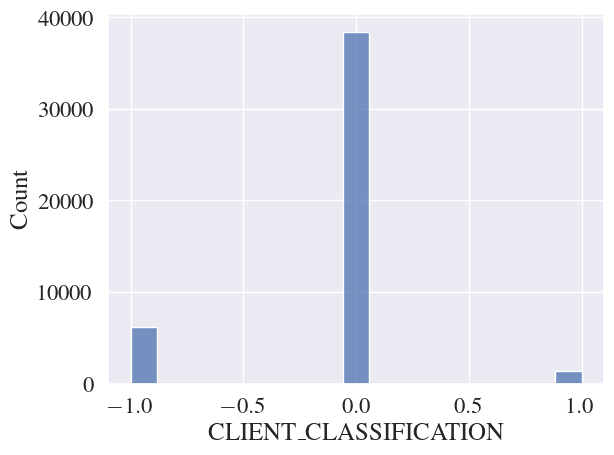

In [15]:
client_classification = df_client_classification['CLIENT_CLASSIFICATION']

# Plot the distribution of the clients
sns.histplot(client_classification)
save_plot('client_classification.pdf')
plt.show()

In [16]:
# Percentages of each client
df_client_classification['CLIENT_CLASSIFICATION'].value_counts(normalize=True)*100



 0    83.596825
-1    13.319561
 1     3.083614
Name: CLIENT_CLASSIFICATION, dtype: float64

* It means that around 83% of my dataset is composed of good clients, 13% did not use their credit card in the past few months and only 3% are bad payers. 
* It's not highly unbalanced, but still unbalanced.
* I do not wanna classify the guys who do not use their cards, so in the very end my working dataset will contain only the classes 1 and 0.

### 2.Credit application dataframe 

In [17]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [18]:
df_application.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


* We observe that the days employed has a maximum value of 365243.000000. This are the unemployed people of the dataset.
* In this dataframe we have categorical (object) and numerical variables.
* The categorical variables will be encoded and the numerical will be scaled to use the models I intend to use: Logistic regression, Random Forest, XGBoost and KNeighrest neighbors.
* How are these variables?

In [16]:
df_application.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


* There are 3 features that call my attention:
    * Days employed and days birth are counting the days backwards in time. I want them to be easy to understand numbers, so I'll treat them before training my models.
    * Occupation type has some Nan values, i.e., this information was not provided.
    
* Also, clearly **I can create 2 interesting features**:
    * Total income divided by the family members, and
    * Total income divided by the number of children
* It might have some impact on how the person use their credit card and how they manage their finances. It is all about salary income that is compromised.
* An important question: Are there repeated IDs in the dataset?

In [19]:
sum(df_application['ID'].duplicated())

47

* There are 47 repeated IDs, do they refer to the same person?

In [20]:
df_application[df_application['ID'].isin(df_application['ID'][df_application['ID'].duplicated()])].sort_values('ID')


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
426818,7022197,M,Y,Y,3,135000.0,Working,Secondary / secondary special,Married,House / apartment,-11945,-735,1,0,0,1,Laborers,5.0
425023,7022197,F,N,Y,0,450000.0,Commercial associate,Higher education,Separated,House / apartment,-19813,-1799,1,0,0,1,NaN,1.0
431545,7022327,F,N,Y,0,135000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-14771,-5298,1,0,0,0,High skill tech staff,1.0
431911,7022327,M,Y,Y,0,256500.0,Commercial associate,Higher education,Married,House / apartment,-21503,-1674,1,0,0,1,Core staff,2.0
425486,7023108,M,Y,Y,1,67500.0,Working,Secondary / secondary special,Married,House / apartment,-15156,-1696,1,1,0,0,Core staff,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426563,7836711,F,N,Y,2,292500.0,Working,Higher education,Married,House / apartment,-13747,-4386,1,0,1,0,Accountants,4.0
421464,7836971,M,Y,N,1,157500.0,Working,Secondary / secondary special,Married,House / apartment,-13771,-5520,1,0,0,0,NaN,3.0
428620,7836971,F,N,Y,0,103500.0,Working,Secondary / secondary special,Civil marriage,House / apartment,-13383,-2798,1,0,1,0,Sales staff,2.0
422068,7838075,M,N,Y,0,337500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-18198,-1275,1,0,0,1,Drivers,2.0


* The repeated IDs refer to different profiles of clients, they have different genders most of the time. I imagine they are couples. 
* For the moment, since it is just 47 repeated entries, I choose to get rid of the repeated IDs before joining the datasets.
    * Other strategy could be leave the older client.

In [21]:
df_application = df_application.drop_duplicates(subset = 'ID', keep = False, inplace = False)

In [22]:
sum(df_application['ID'].duplicated())

0

### Merging the datasets

In [23]:
df_merged = pd.merge(df_application, df_client_classification, on='ID')

In [24]:
df_merged.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-1


* Checking their shapes

In [25]:
df_application.shape, df_client_classification.shape, df_merged.shape  # Os cabras que nao consiguiram o cartao sao os rejeitados


((438463, 18), (45985, 2), (36457, 19))

In [26]:
len(set(df_application.ID).intersection(set(df_client_classification.ID)))

36457

* It can be interpreted as some of the clients that applied didn't have the credit line, some that already have for a long time are not in the application data set anymore.
* Are there missing values?

In [27]:
np.sum(df_merged.isnull()).T

ID                           0
CODE_GENDER                  0
FLAG_OWN_CAR                 0
FLAG_OWN_REALTY              0
CNT_CHILDREN                 0
AMT_INCOME_TOTAL             0
NAME_INCOME_TYPE             0
NAME_EDUCATION_TYPE          0
NAME_FAMILY_STATUS           0
NAME_HOUSING_TYPE            0
DAYS_BIRTH                   0
DAYS_EMPLOYED                0
FLAG_MOBIL                   0
FLAG_WORK_PHONE              0
FLAG_PHONE                   0
FLAG_EMAIL                   0
OCCUPATION_TYPE          11323
CNT_FAM_MEMBERS              0
CLIENT_CLASSIFICATION        0
dtype: int64

* As we have seen before only the occupation type has missing values.

In [28]:
df_merged['OCCUPATION_TYPE'].count()/df_merged['ID'].count()

0.6894149271744795

In [29]:
df_merged.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453,-0.090051
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686,0.381553
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-1.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000,0.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000,0.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,1.000000


### 3.Data treatment 
In this section I address the following:

1) I pre-process the needed features: DAYS_BIRTH, DAYS_EMPLOYED
2) I create the features: 
    * AMT_INCOME_PER_PERSON that is the ratio between the total income, AMT_INCOME_TOTAL, and the total family members, CNT_FAM_MEMBERS, of each client, and
    * AMT_INCOME_PER_CHILD that is the ratio between the total income, AMT_INCOME_TOTAL, and the total of children, CNT_CHILDREN. This is set to 0 if the client has no children.
    * EMPLOYED: It classifies if the person has a job or not based on the value of the years employed, which after the treatment assumes -1 if unemployed and the years employed >0 if the person has a job.
3) Distributions of the features?
    * I'll also plot some of the interesting features to gain further insigths into the dataset.

#### 1) Dealing with missing values in occupation type

* The OCCUPATION column that has 70% of missing values will have 'Not provided' as Nan.

In [30]:
# Where there is Nan, substitute with Not provided
df_merged['OCCUPATION_TYPE'].fillna('Not provided', inplace = True)

In [31]:
df_merged.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Not provided,2.0,0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,Not provided,2.0,0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-1


In [32]:
np.sum(df_merged.isnull()).T

ID                       0
CODE_GENDER              0
FLAG_OWN_CAR             0
FLAG_OWN_REALTY          0
CNT_CHILDREN             0
AMT_INCOME_TOTAL         0
NAME_INCOME_TYPE         0
NAME_EDUCATION_TYPE      0
NAME_FAMILY_STATUS       0
NAME_HOUSING_TYPE        0
DAYS_BIRTH               0
DAYS_EMPLOYED            0
FLAG_MOBIL               0
FLAG_WORK_PHONE          0
FLAG_PHONE               0
FLAG_EMAIL               0
OCCUPATION_TYPE          0
CNT_FAM_MEMBERS          0
CLIENT_CLASSIFICATION    0
dtype: int64

#### 2) Adjusting age and days employed
* I transform the 'DAYS_BIRTH' into 'AGE' by diving this values by 365.25 (.25 accounts for the leap years)

In [33]:
#the - sign is to take into account the backwards count
df_merged['AGE'] = -round(df_merged['DAYS_BIRTH']/365.25,0) # Create the AGE
df_merged = df_merged.drop('DAYS_BIRTH', axis = 1) #Exclued the days birth

df_merged['YEARS_EMPLOYED'] = -round(df_merged['DAYS_EMPLOYED']/365.25,0)
df_merged = df_merged.drop('DAYS_EMPLOYED', axis = 1)



In [34]:
df_merged.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION,AGE,YEARS_EMPLOYED
count,3.645700e+04,36457.000000,3.645700e+04,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,1.0,0.225526,0.294813,0.089722,2.198453,-0.090051,43.746057,-162.243657
std,4.187524e+04,0.742367,1.017892e+05,0.0,0.417934,0.455965,0.285787,0.911686,0.381553,11.513873,376.881770
min,5.008804e+06,0.000000,2.700000e+04,1.0,0.000000,0.000000,0.000000,1.000000,-1.000000,21.000000,-1000.000000
25%,5.042028e+06,0.000000,1.215000e+05,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,34.000000,1.000000
50%,5.074614e+06,0.000000,1.575000e+05,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,43.000000,4.000000
75%,5.115396e+06,1.000000,2.250000e+05,1.0,0.000000,1.000000,0.000000,3.000000,0.000000,53.000000,9.000000
max,5.150487e+06,19.000000,1.575000e+06,1.0,1.000000,1.000000,1.000000,20.000000,1.000000,69.000000,43.000000


In [35]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     36457 non-null  int64  
 1   CODE_GENDER            36457 non-null  object 
 2   FLAG_OWN_CAR           36457 non-null  object 
 3   FLAG_OWN_REALTY        36457 non-null  object 
 4   CNT_CHILDREN           36457 non-null  int64  
 5   AMT_INCOME_TOTAL       36457 non-null  float64
 6   NAME_INCOME_TYPE       36457 non-null  object 
 7   NAME_EDUCATION_TYPE    36457 non-null  object 
 8   NAME_FAMILY_STATUS     36457 non-null  object 
 9   NAME_HOUSING_TYPE      36457 non-null  object 
 10  FLAG_MOBIL             36457 non-null  int64  
 11  FLAG_WORK_PHONE        36457 non-null  int64  
 12  FLAG_PHONE             36457 non-null  int64  
 13  FLAG_EMAIL             36457 non-null  int64  
 14  OCCUPATION_TYPE        36457 non-null  object 
 15  CN

In [36]:
# The negative values of the years employed refers to the unemployed clients, these are going to be set all to -1.
df_merged.loc[df_merged['YEARS_EMPLOYED'] < 0, 'YEARS_EMPLOYED'] = -1

* Moreover, let's create a binary feature EMPLOYED:

In [37]:
# Define a function to create the 'Employed' feature
def create_employed_feature(x):
    if x >= 0:  # Positive 'YEARS_EMPLOYED'
        return 1
    else:  # 'YEARS_EMPLOYED' is -1 (unemployed)
        return 0

# Apply the function to create the 'Employed' feature
df_merged['EMPLOYED'] = df_merged['YEARS_EMPLOYED'].apply(create_employed_feature)


In [38]:
df_merged.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION,AGE,YEARS_EMPLOYED,EMPLOYED
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Not provided,2.0,0,33.0,12.0,1
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Not provided,2.0,0,33.0,12.0,1
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,0,59.0,3.0,1
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,0,52.0,8.0,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,-1,52.0,8.0,1


In [39]:
df_merged.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION,AGE,YEARS_EMPLOYED,EMPLOYED
count,3.645700e+04,36457.000000,3.645700e+04,36457.0,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.000000,36457.00000
mean,5.078227e+06,0.430315,1.866857e+05,1.0,0.225526,0.294813,0.089722,2.198453,-0.090051,43.746057,5.868503,0.83172
std,4.187524e+04,0.742367,1.017892e+05,0.0,0.417934,0.455965,0.285787,0.911686,0.381553,11.513873,6.653320,0.37412
min,5.008804e+06,0.000000,2.700000e+04,1.0,0.000000,0.000000,0.000000,1.000000,-1.000000,21.000000,-1.000000,0.00000
25%,5.042028e+06,0.000000,1.215000e+05,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,34.000000,1.000000,1.00000
50%,5.074614e+06,0.000000,1.575000e+05,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,43.000000,4.000000,1.00000
75%,5.115396e+06,1.000000,2.250000e+05,1.0,0.000000,1.000000,0.000000,3.000000,0.000000,53.000000,9.000000,1.00000
max,5.150487e+06,19.000000,1.575000e+06,1.0,1.000000,1.000000,1.000000,20.000000,1.000000,69.000000,43.000000,1.00000


In [38]:
#years_employed_for_histogram = df_merged[df_merged['YEARS_EMPLOYED']]

# Plot the distribution of the clients
#sns.histplot(years_employed_for_histogram)
#save_plot('client_classification.pdf')
#plt.show()

#### 3) Feature engineering

* Creating the amount income per person:

In [40]:
# total income / person
df_merged['AMT_INCOME_PER_PERSON'] = df_merged['AMT_INCOME_TOTAL']/df_merged['CNT_FAM_MEMBERS']



* Creating the amount income per child:

In [41]:
def amt_per_child(dataframe):
    if dataframe['CNT_CHILDREN'] == 0:
        return -1 # this is a value that can't exist
    else:
        return dataframe['AMT_INCOME_TOTAL']/dataframe['CNT_CHILDREN']

In [42]:
df_merged['AMT_INCOME_PER_CHILD'] = df_merged.apply(amt_per_child, axis = 1)



In [43]:
np.sum(df_merged.isnull()).T

ID                       0
CODE_GENDER              0
FLAG_OWN_CAR             0
FLAG_OWN_REALTY          0
CNT_CHILDREN             0
AMT_INCOME_TOTAL         0
NAME_INCOME_TYPE         0
NAME_EDUCATION_TYPE      0
NAME_FAMILY_STATUS       0
NAME_HOUSING_TYPE        0
FLAG_MOBIL               0
FLAG_WORK_PHONE          0
FLAG_PHONE               0
FLAG_EMAIL               0
OCCUPATION_TYPE          0
CNT_FAM_MEMBERS          0
CLIENT_CLASSIFICATION    0
AGE                      0
YEARS_EMPLOYED           0
EMPLOYED                 0
AMT_INCOME_PER_PERSON    0
AMT_INCOME_PER_CHILD     0
dtype: int64

#### 4) Creating the working dataset and the one with the "Julius" clients

In [44]:
df_work = df_merged[df_merged['CLIENT_CLASSIFICATION'] != -1]
df_juli = df_merged[df_merged['CLIENT_CLASSIFICATION'] == -1] #juli for Julius

### 4. Some histograms

* What are the interesting features to have a look at?

In [44]:
df_work.columns

Index(['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_MOBIL',
       'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'CLIENT_CLASSIFICATION', 'AGE', 'YEARS_EMPLOYED',
       'EMPLOYED', 'AMT_INCOME_PER_PERSON', 'AMT_INCOME_PER_CHILD'],
      dtype='object')

In [205]:
# Functions for quick visualization of the features in the working dataframe.
def quick_plot_histogram(feature_to_plot):
    # Plot the distribution of the clients
    sns.histplot(feature_to_plot)
    #save_plot('client_classification.pdf')
    plt.show()
    
    return None

def plot_feature_distribution(feature_to_plot, figure_size = (30,30), plt_name = None):
    
    good_clients = df_work.CLIENT_CLASSIFICATION == 0
    bad_clients = df_work.CLIENT_CLASSIFICATION == 1
    
    _, bin_values = np.histogram(df_work[feature_to_plot], bins=15)
    
    plt.figure(figsize = figure_size)
    plt.hist(df_work[feature_to_plot][good_clients], bins = bin_values, density=True, alpha = 0.8, color = 'blue')
    plt.hist(df_work[feature_to_plot][bad_clients], bins = bin_values, density=True, alpha = 0.8, color = 'orange')
    #sns.histplot(df_work[feature_to_plot][good_clients], color='purple',)
    #sns.histplot(df_work[feature_to_plot][bad_clients], color='red')
    plt.legend(['Good', 'Bad'], loc = 'upper left')
    #plt.title(col)
    
    if plt_name == None:
        plt.show()
    else:
        save_plot(plt_name)
        plt.show()
    
    return None

#### 4a) Gender

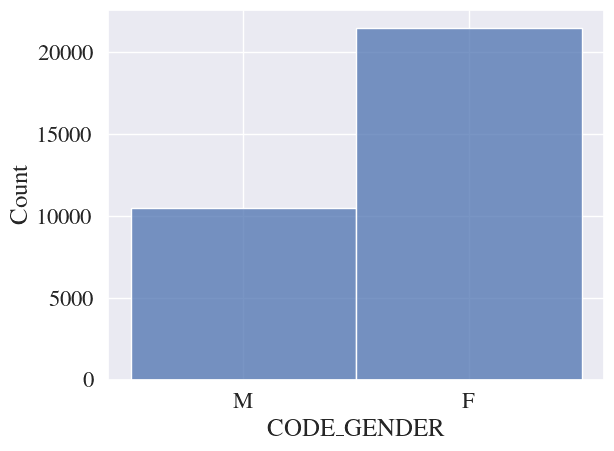

In [46]:
quick_plot_histogram(df_work['CODE_GENDER'])

* From this histogram we observe that most of the clients are women. As this might be a potential feature in classifying good and bad clients I will **completly drop** the gender from my features. Because I do not want to make a sexist machine learning model.
* This is motivated because statiscallly, it is expected that there will be more woman classified as bad clients than man, let's check below:

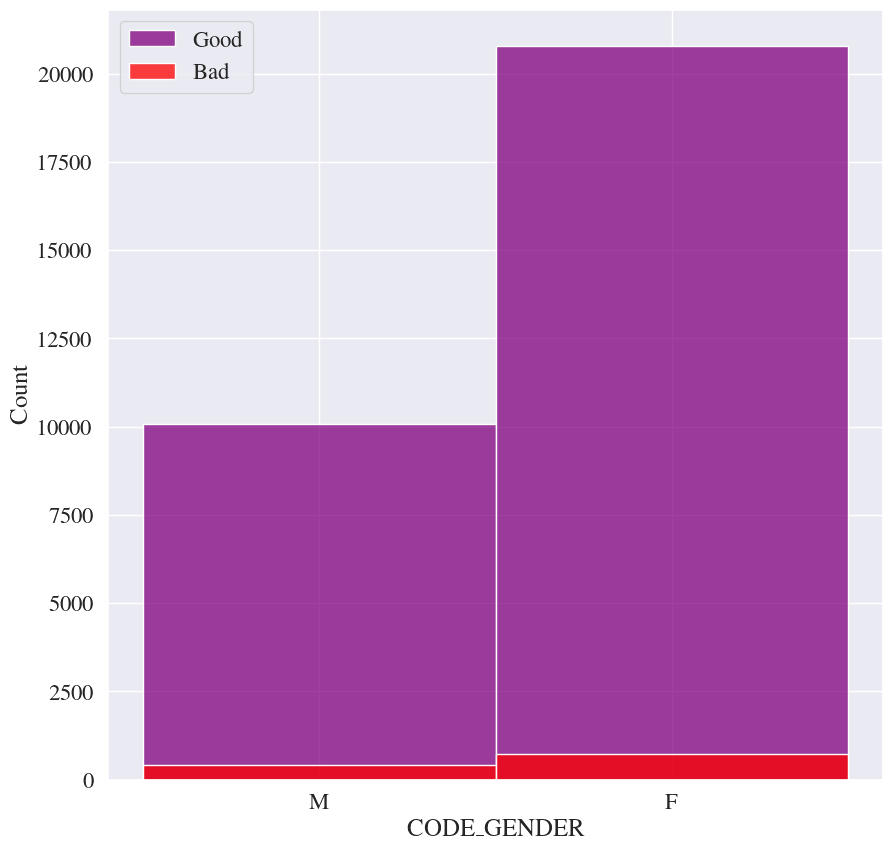

In [47]:
plot_feature_distribution('CODE_GENDER', figure_size = (10,10), plt_name='Gender_histogram.pdf')

* As expected.

#### 4b) Age

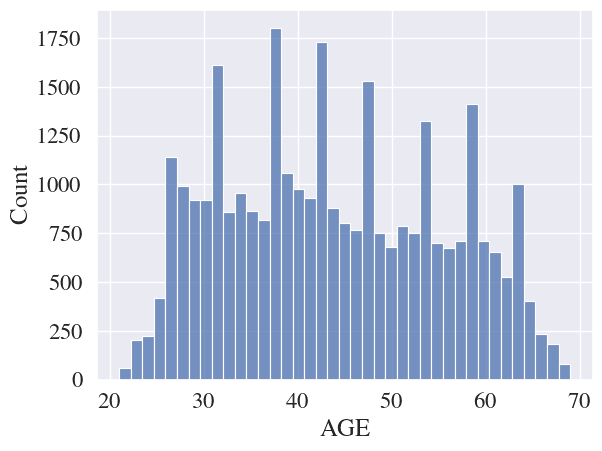

In [48]:
quick_plot_histogram(df_work['AGE'])

In [49]:
df_work['AGE'].max(),df_work['AGE'].min()

(69.0, 21.0)

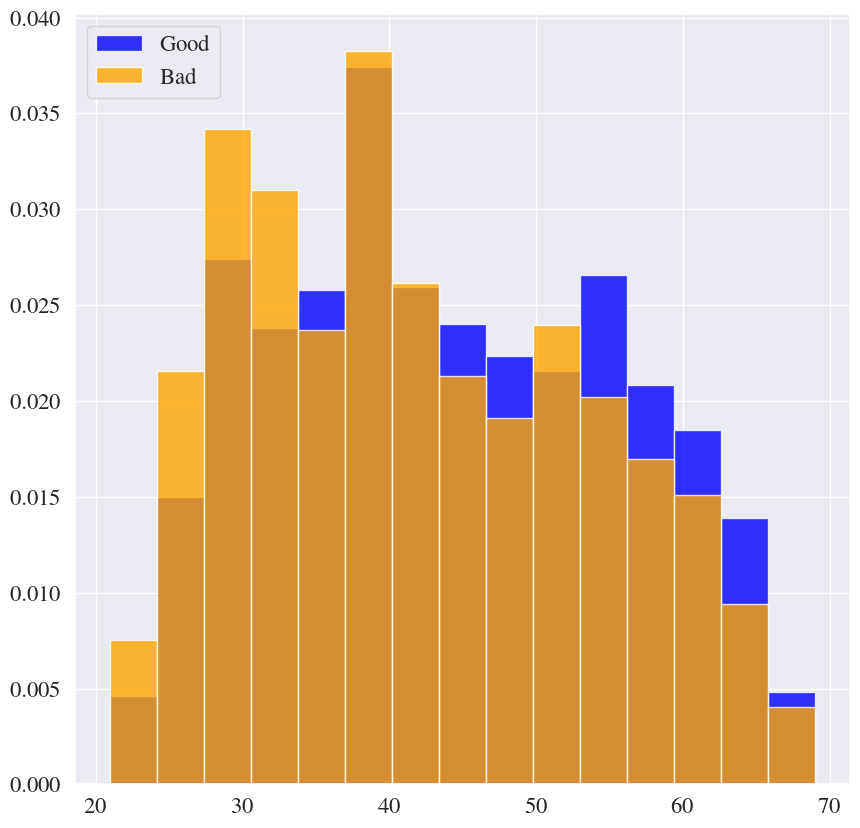

In [206]:
plot_feature_distribution('AGE', figure_size = (10,10), plt_name='Age_distribution.pdf')

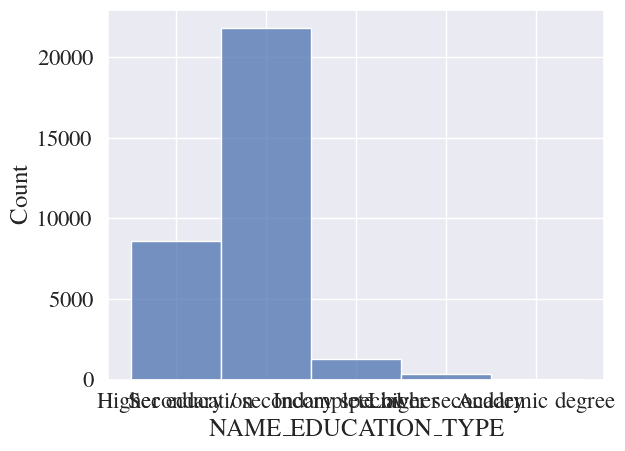

In [51]:
quick_plot_histogram(df_work['NAME_EDUCATION_TYPE'])

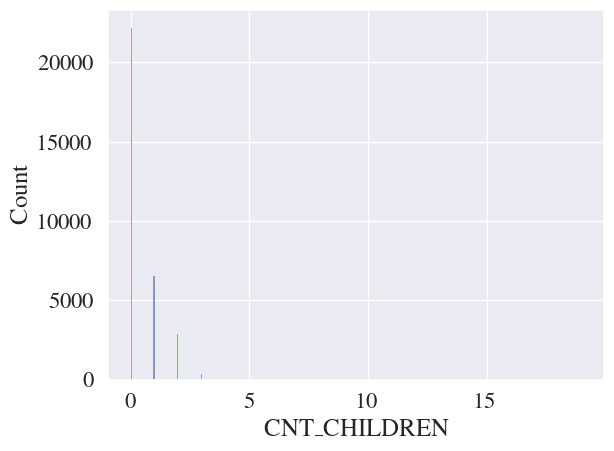

In [53]:
quick_plot_histogram(df_work['CNT_CHILDREN'])

In [54]:
df_work['CNT_CHILDREN'].max(), df_work['CNT_CHILDREN'].min()

(19, 0)

* There is a Mr. Catra with 19 children in the dataset.

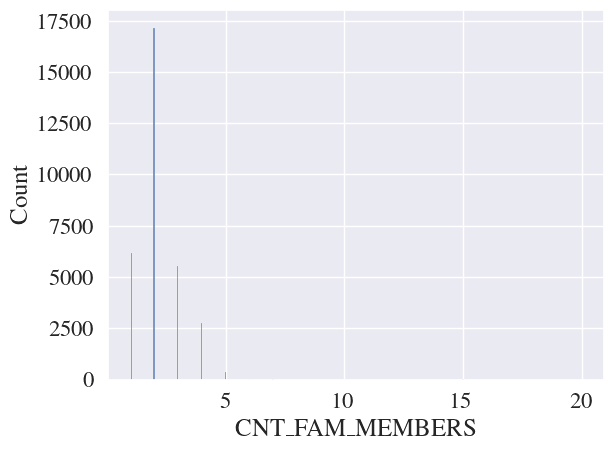

In [208]:
quick_plot_histogram(df_work['CNT_FAM_MEMBERS'])

In [209]:
df_work['CNT_FAM_MEMBERS'].max(), df_work['CNT_FAM_MEMBERS'].min()

(20.0, 1.0)

* The counting of the family members is in accordance with the person who has 19 children.

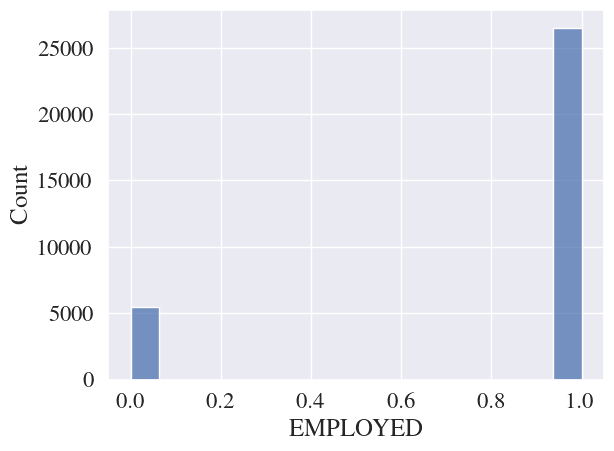

In [57]:
quick_plot_histogram(df_work['EMPLOYED'])

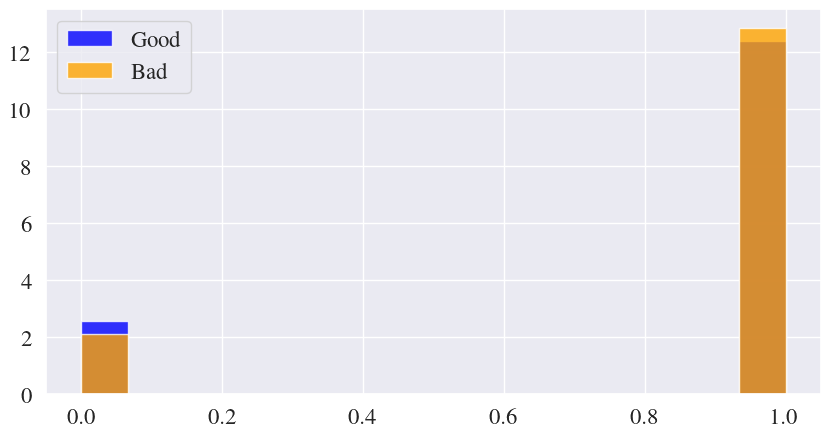

In [210]:
plot_feature_distribution('EMPLOYED', figure_size=(10,5), plt_name='Employment_status.pdf')

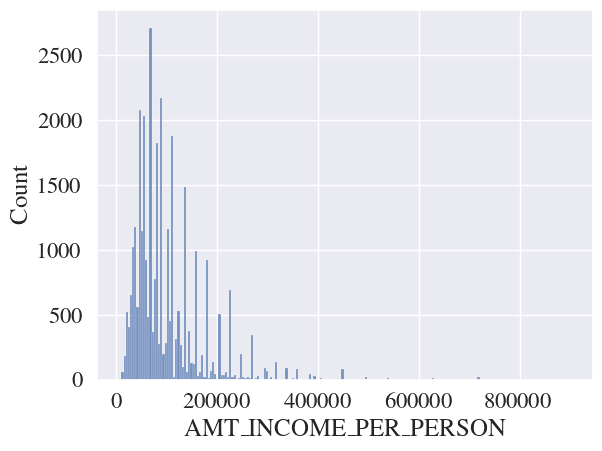

In [59]:
quick_plot_histogram(df_work['AMT_INCOME_PER_PERSON'])

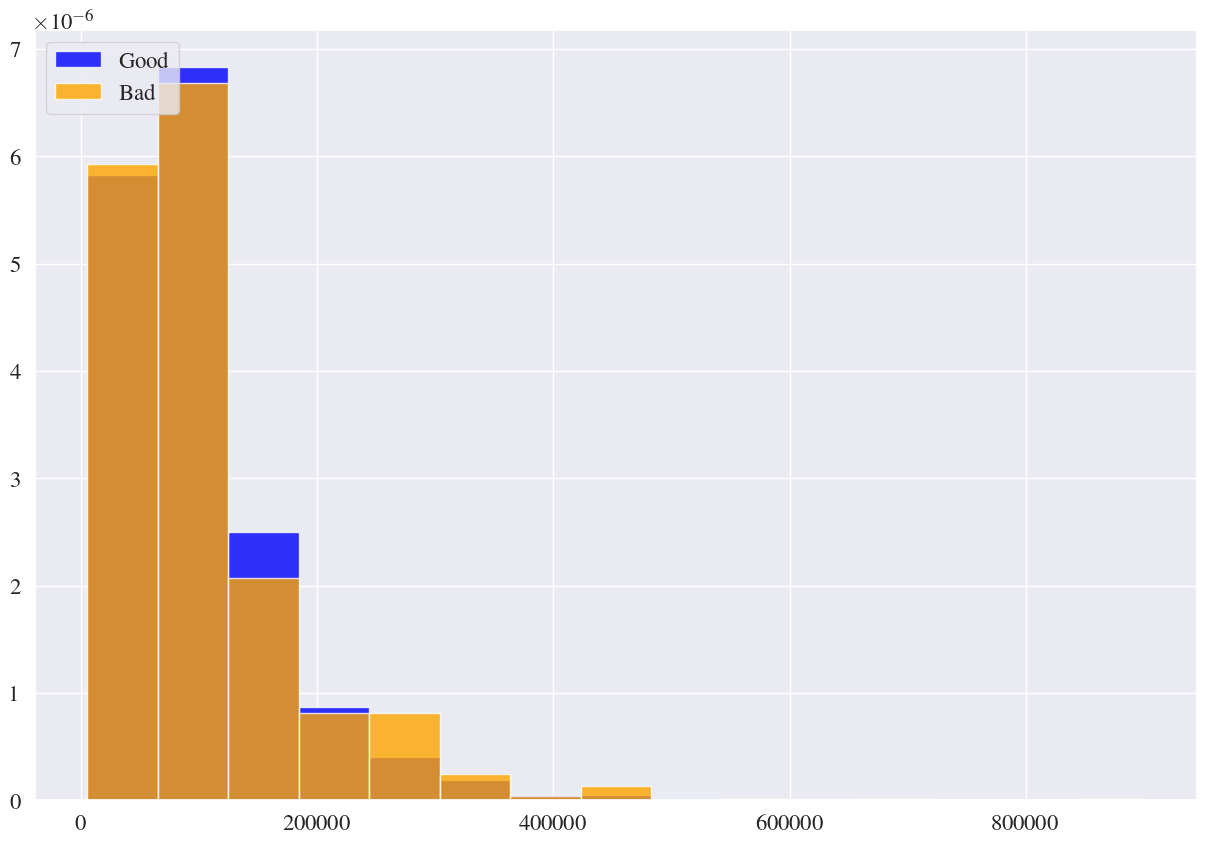

In [211]:
plot_feature_distribution('AMT_INCOME_PER_PERSON',figure_size=(15,10), plt_name='Income_per_person_distribution.pdf')

In [212]:
df_work['AMT_INCOME_PER_PERSON'].max(), df_work['AMT_INCOME_PER_PERSON'].min()

(900000.0, 5625.0)

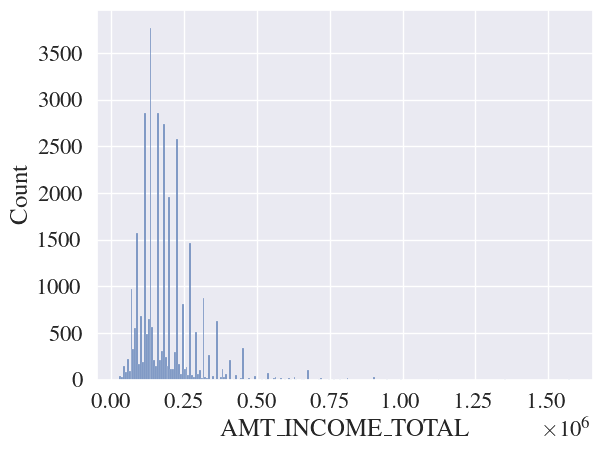

In [65]:
quick_plot_histogram(df_work['AMT_INCOME_TOTAL'])

In [66]:
df_work['AMT_INCOME_TOTAL'].max(), df_work['AMT_INCOME_TOTAL'].min()

(1575000.0, 27000.0)

## Part 2: Modeling and training

This is the core of this project. The steps are as indicated:
It is important to take into account that this dataset is highly unbalanced. I will not use any resempling technique. Undersampling makes us loose information, oversample can lead to high bias and SMOTE does not work well.  
1. I'll use the following models to this problem:
    * Logistic regression
    * Random Forest
    * XGBoost
    * KNeighbors
* I do not want to train **sexist models**, i.e., a model that takes into account the gender of the client when classifiyng him/her as a good or bad payer.
  
* In a first moment I'll just run the models with the default parameters and check what is the ROC-AUC and $f_1$ scores. Then, for each model I will perform a **hyperparameter optimization** for the best models
* I'll use 10-fold cross validation
    * I'll use the ROC-AUC as the main classification metric, I'll also check which is the best threshold to set to obtain a good tradeoff between precision and recall.
2. Feature importance for each model.

4. Models performance evaluation (using test dataset)
    * Predictions in the test dataset
    * The veredict **confusion matrices**
    * Classification report for the chosen model
    
5. Summary and discussion
    * Chosen model and figures of merit
    
A cool answer I found looking for some interpretation on ROC and $f_1$ scores: 
   * high AUC ROC vs low f1 or other "point" metric, means that your classifier currently does a bad job, however you can find the threshold for which its score is actually pretty decent
   * low AUC ROC and low f1 or other "point" metric, means that your classifier currently does a bad job, and even fitting a threshold will not change it
   * high AUC ROC and high f1 or other "point" metric, means that your classifier currently does a decent job, and for many other values of threshold it would do the same
   * low AUC ROC vs high f1 or other "point" metric, means that your classifier currently does a decent job, however for many other values of threshold - it is pretty bad

    
#### References
1. Treating unbalanced datasets (in portuguese): https://medium.com/datalab-log/voc%C3%AA-deve-calibrar-seu-modelo-desbalanceado-ou-n%C3%A3o-3f111160653a
2. XGBoost tutorial: https://www.datacamp.com/tutorial/xgboost-in-python
3. SVM tutorial: https://www.datacamp.com/tutorial/svm-classification-scikit-learn-python
4. KNeighbors tutorial: https://www.datacamp.com/tutorial/k-nearest-neighbor-classification-scikit-learn
5. LighGBM documentation: https://lightgbm.readthedocs.io/en/stable/
6. StackExchange discussion: https://stackoverflow.com/questions/34698161/how-to-interpret-almost-perfect-accuracy-and-auc-roc-but-zero-f1-score-precisio
7. Pipeline construction: https://towardsdatascience.com/building-a-machine-learning-pipeline-3bba20c2352b
8. Feature importance - Permutation importance vs. Random Forest Feature Importance: https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance.html#sphx-glr-auto-examples-inspection-plot-permutation-importance-py

#### 1) Training, calibration and test sets

In [67]:
# The target is
y = df_work.CLIENT_CLASSIFICATION

# I take off the ID and GENDER and the target
X = df_work.drop(['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION'], axis =1)

# The columns that has numerical features
numerical_features = X.select_dtypes(include=['float64', 'int64']).columns

# The categorical features
categorical_features = X.select_dtypes(include=['object']).columns

# These columns need encoding
print(categorical_features)
print(numerical_features)

Index(['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE',
       'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE'],
      dtype='object')
Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'AGE', 'YEARS_EMPLOYED',
       'EMPLOYED', 'AMT_INCOME_PER_PERSON', 'AMT_INCOME_PER_CHILD'],
      dtype='object')


In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,stratify=y)


X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size=0.1, random_state=42, stratify=y_train)



In [69]:
X_test.shape

(6403, 19)

In [70]:
X_train.shape

(23049, 19)

In [71]:
X_calib.shape

(2562, 19)

#### General preprocessing steps

In [72]:
# To scale numerical features
scaler = RobustScaler()

# To encode categorical features
encoder = ce.TargetEncoder(cols = categorical_features)

# Making a preprocessor with the scaler and encoder
preprocessor = ColumnTransformer(
      transformers=[('numerical_features', scaler, numerical_features),
                    ('categorical_features', encoder, categorical_features)])

* I'll mostly be using tree based models, so the scaler is somehow indifferent, but for the Logistic regression and KNearest Neighbors model the scaling of the numerical features is important. 
* For **consistency** of the comparison I apply the same pre-processing for all models, i.e., the numerical and categorical features are always scaled and encoded in the same manner.

#### 0.Simple model 
* Here I want to have a baseline. If I consider a very simple function, is it already enough to classify the users?

In [74]:
def simple_model(df, a = 1):#, w = 1/(200*10**3), e = 2):
    age = df.AGE
    salary = df.AMT_INCOME_TOTAL
    employment_time = df.YEARS_EMPLOYED
    
    return - a*age #+ w*salary + e*employment_time

In [75]:
simple_model(X_test)

22635   -64.0
24569   -40.0
14271   -55.0
4884    -36.0
12647   -56.0
         ... 
22496   -59.0
32292   -50.0
20743   -57.0
2761    -42.0
2839    -57.0
Name: AGE, Length: 6403, dtype: float64

In [76]:
roc_auc_score(y_test, simple_model(X_test))

0.5566742941120592

#### 1. Training default models and checking the ROC-AUC provided


In [77]:
def train_default_model(model, X_train = X_train, y_train = y_train, X_test = X_test):
    mdl = make_pipeline(preprocessor, model)
    mdl.fit(X_train, y_train)

    pred = mdl.predict_proba(X_test)[:,1]
    
    rocauc = roc_auc_score(y_test, pred)
    
    return rocauc

In [78]:
train_default_model(LogisticRegression())

0.5271151492800027

In [79]:
train_default_model(RandomForestClassifier())

0.7094526539598455

In [80]:
train_default_model(XGBClassifier())

0.6350696947345481

In [81]:
train_default_model(KNeighborsClassifier())

0.6276601763532429

* The sklearn default models (potentially overfitting the training set) provide a ROC-AUC that is going to be our baseline.
    * The logistic regression is basically tossing a coin and it's performing worst than my simple model considering only the age!
    * The Random forest is performing quite well! But it is overfitting, of course.
    * XGBoost doesn't outperform the Random forest but is the second in the rank.
    * Finally, the KNeighrest neighbors is better than the logistic regression but worst than the tree based methods.

#### Functions to do hyperparameter optimization

In [82]:
def train_LR(params, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    C = params[0]
    solver = params[1]
    max_iter = params[2]
    tol = params[3]
    
    model = LogisticRegression(C=C, solver=solver, max_iter=max_iter,tol=tol, class_weight='balanced')
    
    mdl = make_pipeline(preprocessor, model)
    
    mdl.fit(X_train, y_train)
    
    pred = mdl.predict_proba(X_test)[:,1]
    
    return -roc_auc_score(y_test, pred)

parameter_space_LR = [
    (0.001, 10.0),  # C (Regularization Strength)
    ('liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'),  # solver
    (100, 10000),   # max_iter (Max Iterations)
    (1e-4, 1e-2)   # tol (Tolerance)
]

In [83]:
%%time
optimization_result_LR = dummy_minimize(train_LR, parameter_space_LR, random_state=42,verbose=1,n_calls = 100)


Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.3838
Function value obtained: -0.5354
Current minimum: -0.5354
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.3388
Function value obtained: -0.5339
Current minimum: -0.5354
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3666
Function value obtained: -0.5355
Current minimum: -0.5355
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.1485
Function value obtained: -0.5360
Current minimum: -0.5360
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.9206
Function value obtained: -0.5319
Current minimum: -0.5360
Iteration No: 6 started.

/Users/brunogoes/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Iteration No: 7 ended. Evaluation done at random point.
Time taken: 1.8580
Function value obtained: -0.5287
Current minimum: -0.5360
Iteration No: 8 started. Evaluating function at random point.
Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.3688
Function value obtained: -0.5352
Current minimum: -0.5360
Iteration No: 9 started. Evaluating function at random point.
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 0.4800
Function value obtained: -0.5278
Current minimum: -0.5360
Iteration No: 10 started. Evaluating function at random point.
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 3.3254
Function value obtained: -0.5350
Current minimum: -0.5360
Iteration No: 11 started. Evaluating function at random point.
Iteration No: 11 ended. Evaluation done at random point.
Time taken: 0.3465
Function value obtained: -0.5356
Current minimum: -0.5360
Iteration No: 12 started. Evaluating function at random point.
Iteration No: 12 end

Iteration No: 49 ended. Evaluation done at random point.
Time taken: 0.7397
Function value obtained: -0.5308
Current minimum: -0.5360
Iteration No: 50 started. Evaluating function at random point.
Iteration No: 50 ended. Evaluation done at random point.
Time taken: 0.2894
Function value obtained: -0.5356
Current minimum: -0.5360
Iteration No: 51 started. Evaluating function at random point.
Iteration No: 51 ended. Evaluation done at random point.
Time taken: 0.3123
Function value obtained: -0.5356
Current minimum: -0.5360
Iteration No: 52 started. Evaluating function at random point.
Iteration No: 52 ended. Evaluation done at random point.
Time taken: 0.6885
Function value obtained: -0.5297
Current minimum: -0.5360
Iteration No: 53 started. Evaluating function at random point.
Iteration No: 53 ended. Evaluation done at random point.
Time taken: 2.0858
Function value obtained: -0.5328
Current minimum: -0.5360
Iteration No: 54 started. Evaluating function at random point.
Iteration No: 5

Iteration No: 91 ended. Evaluation done at random point.
Time taken: 0.3625
Function value obtained: -0.5358
Current minimum: -0.5363
Iteration No: 92 started. Evaluating function at random point.
Iteration No: 92 ended. Evaluation done at random point.
Time taken: 1.3537
Function value obtained: -0.5339
Current minimum: -0.5363
Iteration No: 93 started. Evaluating function at random point.
Iteration No: 93 ended. Evaluation done at random point.
Time taken: 0.5855
Function value obtained: -0.5262
Current minimum: -0.5363
Iteration No: 94 started. Evaluating function at random point.
Iteration No: 94 ended. Evaluation done at random point.
Time taken: 0.3804
Function value obtained: -0.5354
Current minimum: -0.5363
Iteration No: 95 started. Evaluating function at random point.
Iteration No: 95 ended. Evaluation done at random point.
Time taken: 0.7303
Function value obtained: -0.5278
Current minimum: -0.5363
Iteration No: 96 started. Evaluating function at random point.
Iteration No: 9

In [84]:
optimization_result_LR.fun

-0.5362799579792019

In [85]:
best_parameters_LR = optimization_result_LR.x
best_parameters_LR

[6.919260081729242, 'sag', 8452, 0.00027894609979365665]

In [86]:
def train_RF(params, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    n_estimators = params[0]
    criterion = params[1]
    max_depth = params[2]
    min_samples_split = params[3]
    min_samples_leaf = params[4]
    class_weight = params[5]
    
    model = RandomForestClassifier(n_estimators= n_estimators, criterion = criterion, max_depth=max_depth, min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf, class_weight=class_weight, n_jobs = -1, random_state=42)
    
    mdl = make_pipeline(preprocessor, model)
    
    mdl.fit(X_train, y_train)
    
    pred = mdl.predict_proba(X_test)[:,1]
    
    return -roc_auc_score(y_test, pred)

parameter_space_RF = [(100,500),          #n_estimators
                     ('gini','entropy'),  #criterion
                     (10,30),             #max_depth
                     (2,20),              #min_samples_split
                     (5,20),              #min_samples_leaf
                     ("balanced", "balanced_subsample")]  #Class_weigth




In [87]:
%%time
optimization_result_RF = dummy_minimize(train_RF, parameter_space_RF, random_state=42,verbose=1,n_calls = 100)



Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.5766
Function value obtained: -0.6424
Current minimum: -0.6424
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.4440
Function value obtained: -0.6423
Current minimum: -0.6424
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.9350
Function value obtained: -0.6591
Current minimum: -0.6591
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 2.2021
Function value obtained: -0.6429
Current minimum: -0.6591
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.9817
Function value obtained: -0.6443
Current minimum: -0.6591
Iteration No: 6 started. 

Iteration No: 43 ended. Evaluation done at random point.
Time taken: 1.3099
Function value obtained: -0.6398
Current minimum: -0.6591
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 0.7694
Function value obtained: -0.6251
Current minimum: -0.6591
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 1.8019
Function value obtained: -0.6483
Current minimum: -0.6591
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. Evaluation done at random point.
Time taken: 2.2280
Function value obtained: -0.6414
Current minimum: -0.6591
Iteration No: 47 started. Evaluating function at random point.
Iteration No: 47 ended. Evaluation done at random point.
Time taken: 0.8790
Function value obtained: -0.6428
Current minimum: -0.6591
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 4

Iteration No: 85 ended. Evaluation done at random point.
Time taken: 1.9298
Function value obtained: -0.6389
Current minimum: -0.6591
Iteration No: 86 started. Evaluating function at random point.
Iteration No: 86 ended. Evaluation done at random point.
Time taken: 1.6520
Function value obtained: -0.6477
Current minimum: -0.6591
Iteration No: 87 started. Evaluating function at random point.
Iteration No: 87 ended. Evaluation done at random point.
Time taken: 2.8161
Function value obtained: -0.6499
Current minimum: -0.6591
Iteration No: 88 started. Evaluating function at random point.
Iteration No: 88 ended. Evaluation done at random point.
Time taken: 0.6544
Function value obtained: -0.6542
Current minimum: -0.6591
Iteration No: 89 started. Evaluating function at random point.
Iteration No: 89 ended. Evaluation done at random point.
Time taken: 1.0562
Function value obtained: -0.6249
Current minimum: -0.6591
Iteration No: 90 started. Evaluating function at random point.
Iteration No: 9

In [88]:
optimization_result_RF.fun

-0.6591111651272079

In [89]:
best_parameters_RF = optimization_result_RF.x
best_parameters_RF

[249, 'gini', 21, 7, 6, 'balanced']

In [90]:
def train_XGBoost(params, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    n_estimators = params[0]
    max_depth = params[1]
    max_leaves = params[2]
    
    model = XGBClassifier(n_estimators = n_estimators, max_depth = max_depth, max_leaves = max_leaves , n_jobs = -1)
    
    mdl = make_pipeline(preprocessor, model)
    
    mdl.fit(X_train, y_train)
    
    pred = mdl.predict_proba(X_test)[:,1]
    
    return -roc_auc_score(y_test, pred)

parameter_space_XGB = [(100,500), #n_estimators
                     (10,30),     #max_depth
                     (2,20)]      #max_leaves

In [91]:
%%time
optimizaion_result_XGB = dummy_minimize(train_XGBoost, parameter_space_XGB, random_state=42,verbose=1,n_calls = 100)



Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 9.1019
Function value obtained: -0.6643
Current minimum: -0.6643
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 4.0189
Function value obtained: -0.6567
Current minimum: -0.6643
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.1010
Function value obtained: -0.6509
Current minimum: -0.6643
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 4.3447
Function value obtained: -0.6570
Current minimum: -0.6643
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 5.4043
Function value obtained: -0.6499
Current minimum: -0.6643
Iteration No: 6 started. 

Iteration No: 43 ended. Evaluation done at random point.
Time taken: 4.5623
Function value obtained: -0.6588
Current minimum: -0.6655
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 2.2687
Function value obtained: -0.6652
Current minimum: -0.6655
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 7.0600
Function value obtained: -0.6581
Current minimum: -0.6655
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. Evaluation done at random point.
Time taken: 3.7332
Function value obtained: -0.6621
Current minimum: -0.6655
Iteration No: 47 started. Evaluating function at random point.
Iteration No: 47 ended. Evaluation done at random point.
Time taken: 4.7330
Function value obtained: -0.6592
Current minimum: -0.6655
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 4

Iteration No: 85 ended. Evaluation done at random point.
Time taken: 4.1845
Function value obtained: -0.6477
Current minimum: -0.6655
Iteration No: 86 started. Evaluating function at random point.
Iteration No: 86 ended. Evaluation done at random point.
Time taken: 4.7924
Function value obtained: -0.6518
Current minimum: -0.6655
Iteration No: 87 started. Evaluating function at random point.
Iteration No: 87 ended. Evaluation done at random point.
Time taken: 2.6571
Function value obtained: -0.6502
Current minimum: -0.6655
Iteration No: 88 started. Evaluating function at random point.
Iteration No: 88 ended. Evaluation done at random point.
Time taken: 9.9804
Function value obtained: -0.6616
Current minimum: -0.6655
Iteration No: 89 started. Evaluating function at random point.
Iteration No: 89 ended. Evaluation done at random point.
Time taken: 3.5278
Function value obtained: -0.6490
Current minimum: -0.6655
Iteration No: 90 started. Evaluating function at random point.
Iteration No: 9

In [98]:
optimizaion_result_XGB.fun

-0.6654547969087892

In [99]:
best_parameters_XGB = optimizaion_result_XGB.x
best_parameters_XGB

[266, 27, 5]

In [94]:
def train_KNeighbors(params, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    par0 = params[0]
    par1 = params[1]
    par2 = params[2]
    par3 = params[3]
    
    
    model = KNeighborsClassifier(n_neighbors=par0, weights=par1, leaf_size=par2, p=par3)
    
    mdl = make_pipeline(preprocessor, model)

    mdl.fit(X_train, y_train)

    pred = mdl.predict_proba(X_test)[:,1]

    return -roc_auc_score(y_test, pred)

parameter_space_K = [(1,40), # number of neighbors
                      ('uniform', 'distance'), #weights
                      (1,50), # leaf size
                      [1,2]] #p Manhatan or euclidian distance

In [95]:
%%time
optimization_result_KNeighbors = dummy_minimize(train_KNeighbors, parameter_space_K, random_state=42, verbose=1, n_calls = 100)



Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7907
Function value obtained: -0.5944
Current minimum: -0.5944
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.6488
Function value obtained: -0.6055
Current minimum: -0.6055
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3254
Function value obtained: -0.6115
Current minimum: -0.6115
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.3453
Function value obtained: -0.6625
Current minimum: -0.6625
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.6744
Function value obtained: -0.5981
Current minimum: -0.6625
Iteration No: 6 started. 

Iteration No: 43 ended. Evaluation done at random point.
Time taken: 0.6401
Function value obtained: -0.6174
Current minimum: -0.6743
Iteration No: 44 started. Evaluating function at random point.
Iteration No: 44 ended. Evaluation done at random point.
Time taken: 0.6512
Function value obtained: -0.6250
Current minimum: -0.6743
Iteration No: 45 started. Evaluating function at random point.
Iteration No: 45 ended. Evaluation done at random point.
Time taken: 0.3596
Function value obtained: -0.6625
Current minimum: -0.6743
Iteration No: 46 started. Evaluating function at random point.
Iteration No: 46 ended. Evaluation done at random point.
Time taken: 0.3644
Function value obtained: -0.6625
Current minimum: -0.6743
Iteration No: 47 started. Evaluating function at random point.
Iteration No: 47 ended. Evaluation done at random point.
Time taken: 0.6599
Function value obtained: -0.6194
Current minimum: -0.6743
Iteration No: 48 started. Evaluating function at random point.
Iteration No: 4

Iteration No: 85 ended. Evaluation done at random point.
Time taken: 0.3392
Function value obtained: -0.5821
Current minimum: -0.6745
Iteration No: 86 started. Evaluating function at random point.
Iteration No: 86 ended. Evaluation done at random point.
Time taken: 0.3376
Function value obtained: -0.6200
Current minimum: -0.6745
Iteration No: 87 started. Evaluating function at random point.
Iteration No: 87 ended. Evaluation done at random point.
Time taken: 0.3788
Function value obtained: -0.6609
Current minimum: -0.6745
Iteration No: 88 started. Evaluating function at random point.
Iteration No: 88 ended. Evaluation done at random point.
Time taken: 0.3653
Function value obtained: -0.5791
Current minimum: -0.6745
Iteration No: 89 started. Evaluating function at random point.
Iteration No: 89 ended. Evaluation done at random point.
Time taken: 0.3594
Function value obtained: -0.5742
Current minimum: -0.6745
Iteration No: 90 started. Evaluating function at random point.
Iteration No: 9

In [100]:
optimization_result_KNeighbors.fun

-0.6744914337920975

In [101]:
best_parameters_KNeighbors = optimization_result_KNeighbors.x
best_parameters_KNeighbors

[35, 'distance', 16, 1]

In [102]:
# Collecting the best parameters
best_parameters_LR = [6.919260081729242, 'sag', 8452, 0.00027894609979365665]
best_parameters_RF = [249, 'gini', 21, 7, 6, 'balanced']
best_parameters_XGB = [266, 27, 5]
best_parameters_KNeighbors = [35, 'distance', 16, 1]

* Now we have the parameters that provide the highest ROC-AUC for each model. These are going to be the values from now on.
* Next steps are to check the cross validation and the $f_1$, precision and recal scores for each model, with the appropriate threshold.
* Also, I'll check the permutation importance. And for the random forest I can see the Random forest importance.
* These steps will conclude the analysis of the models.

In [103]:
# The models with the optimized hyperparameters are:
LR_with_optimized_parameters = LogisticRegression(C=best_parameters_LR[0], solver=best_parameters_LR[1], max_iter=best_parameters_LR[2],tol=best_parameters_LR[3], class_weight='balanced')
RF_with_optimized_parameters = RandomForestClassifier(n_estimators= best_parameters_RF[0], criterion = best_parameters_RF[1], max_depth=best_parameters_RF[2], min_samples_split=best_parameters_RF[3],min_samples_leaf=best_parameters_RF[4], class_weight=best_parameters_RF[5], n_jobs = -1, random_state=42)
XGB_with_optimized_parameters = XGBClassifier(n_estimators = best_parameters_XGB[0], max_depth = best_parameters_XGB[1], max_leaves = best_parameters_XGB[2], n_jobs = -1)
KN_with_optimized_parameters = KNeighborsClassifier(n_neighbors=best_parameters_KNeighbors[0], weights=best_parameters_KNeighbors[1], leaf_size=best_parameters_KNeighbors[2], p=best_parameters_KNeighbors[3])

In [104]:
# The optimal pipelines for each models are:

pipeline_LR_optimal = make_pipeline(preprocessor, LR_with_optimized_parameters)
pipeline_RF_optimal = make_pipeline(preprocessor, RF_with_optimized_parameters)
pipeline_XGB_optimal= make_pipeline(preprocessor, XGB_with_optimized_parameters)
pipeline_KN_optimal = make_pipeline(preprocessor, KN_with_optimized_parameters) 

* How are the 10-fold cross-validated scores for each model?

#### ROC-AUC 10-fold cross-validation for each model

In [105]:
%%time
LR_rocauc_cross_validated_score = cross_val_score(pipeline_LR_optimal, X_train, y_train, scoring='roc_auc', cv = 10)
LR_rocauc_mean_score = LR_rocauc_cross_validated_score.mean()
LR_rocauc_std = LR_rocauc_cross_validated_score.std()

LR_rocauc_cross_validated_score, LR_rocauc_mean_score, LR_rocauc_std



CPU times: user 38.5 s, sys: 2.51 s, total: 41 s
Wall time: 33.7 s


(array([0.53585449, 0.53860085, 0.54910913, 0.59763265, 0.52148056,
        0.54470048, 0.58959392, 0.55554394, 0.57833773, 0.58504798]),
 0.5595901733497401,
 0.0248016735428327)

In [106]:
%%time
RF_rocauc_cross_validated_score = cross_val_score(pipeline_RF_optimal, X_train, y_train, scoring='roc_auc', cv = 10)
RF_rocauc_mean_score = RF_rocauc_cross_validated_score.mean()
RF_rocauc_std = RF_rocauc_cross_validated_score.std()

RF_rocauc_cross_validated_score, RF_rocauc_mean_score, RF_rocauc_std

CPU times: user 5.22 s, sys: 1.77 s, total: 6.98 s
Wall time: 10.2 s


(array([0.62965363, 0.66588225, 0.71292009, 0.67495906, 0.67691784,
        0.65941178, 0.63647863, 0.70509584, 0.66026136, 0.67584069]),
 0.6697421171818104,
 0.024809611394045705)

In [107]:
%%time
XGB_rocauc_cross_validated_score = cross_val_score(pipeline_XGB_optimal, X_train, y_train, scoring='roc_auc', cv = 10)
XGB_rocauc_mean_score = XGB_rocauc_cross_validated_score.mean()
XGB_rocauc_std = XGB_rocauc_cross_validated_score.std()

XGB_rocauc_cross_validated_score, XGB_rocauc_mean_score, XGB_rocauc_std

CPU times: user 12min 54s, sys: 9.33 s, total: 13min 3s
Wall time: 50.3 s


(array([0.65287703, 0.68398707, 0.70749786, 0.67159186, 0.65207918,
        0.6827925 , 0.64683969, 0.70115617, 0.69458202, 0.68331588]),
 0.6776719269819808,
 0.020204881180689537)

In [108]:
%%time
KN_rocauc_cross_validated_score = cross_val_score(pipeline_KN_optimal, X_train, y_train, scoring='roc_auc', cv = 10)
KN_rocauc_mean_score = KN_rocauc_cross_validated_score.mean()
KN_rocauc_std = KN_rocauc_cross_validated_score.std()

KN_rocauc_cross_validated_score, KN_rocauc_mean_score, KN_rocauc_std

CPU times: user 25 s, sys: 624 ms, total: 25.6 s
Wall time: 3.28 s


(array([0.67397493, 0.64684752, 0.69895785, 0.67767289, 0.65887577,
        0.6897499 , 0.69625705, 0.67176947, 0.67178555, 0.64218332]),
 0.6728074248265699,
 0.018313322145999518)

* In the end, the 10-fold cross-validated score for the tree based models are higher than KNeighbors.
* What about the $f_1$ score?

#### $f_1$ score 10-fold cross-validated for each model

In [109]:
%%time
LR_f1_cross_validated_score = cross_val_score(pipeline_LR_optimal, X_train, y_train, scoring='f1', cv = 10)
LR_f1_mean_score = LR_f1_cross_validated_score.mean()
LR_f1_std = LR_f1_cross_validated_score.std()

LR_f1_cross_validated_score, LR_f1_mean_score, LR_f1_std



CPU times: user 41.1 s, sys: 2.57 s, total: 43.7 s
Wall time: 35.1 s


(array([0.07169811, 0.07843137, 0.07371484, 0.0950495 , 0.07961165,
        0.07692308, 0.08236347, 0.07763401, 0.07699901, 0.08084697]),
 0.07932720238291843,
 0.006028031578360114)

* Ok, there is something really off with the Logistic regression

In [110]:
%%time
RF_f1_cross_validated_score = cross_val_score(pipeline_RF_optimal, X_train, y_train, scoring='f1', cv = 10)
RF_f1_mean_score = RF_f1_cross_validated_score.mean()
RF_f1_std = RF_f1_cross_validated_score.std()

RF_f1_cross_validated_score, RF_f1_mean_score, RF_f1_std

CPU times: user 5.19 s, sys: 1.47 s, total: 6.66 s
Wall time: 8.46 s


(array([0.19090909, 0.20087336, 0.25      , 0.2122449 , 0.18333333,
        0.24150943, 0.22672065, 0.22040816, 0.20920502, 0.20627803]),
 0.2141481977474204,
 0.019967656307137125)

* The RF is horrible... why?

In [111]:
%%time
XGB_f1_cross_validated_score = cross_val_score(pipeline_XGB_optimal, X_train, y_train, scoring='f1', cv = 10)
XGB_f1_mean_score = XGB_f1_cross_validated_score.mean()
XGB_f1_std = XGB_f1_cross_validated_score.std()

XGB_f1_cross_validated_score, XGB_f1_mean_score, XGB_f1_std

CPU times: user 12min 43s, sys: 7.13 s, total: 12min 51s
Wall time: 49.1 s


(array([0.26229508, 0.21428571, 0.23853211, 0.29310345, 0.22018349,
        0.20338983, 0.23214286, 0.23529412, 0.24347826, 0.24778761]),
 0.23904925176464892,
 0.024209524562683004)

* Not great but it is what it is...

In [112]:
%%time
KN_f1_cross_validated_score = cross_val_score(pipeline_KN_optimal, X_train, y_train, scoring='f1', cv = 10)
KN_f1_mean_score = KN_f1_cross_validated_score.mean()
KN_f1_std = KN_f1_cross_validated_score.std()

KN_f1_cross_validated_score, KN_f1_mean_score, KN_f1_std

CPU times: user 29.2 s, sys: 466 ms, total: 29.6 s
Wall time: 3.65 s


(array([0.26666667, 0.21238938, 0.23853211, 0.27826087, 0.22018349,
        0.20338983, 0.23214286, 0.23333333, 0.24347826, 0.26086957]),
 0.23892463601647546,
 0.022835842659055933)

* Same...

In [113]:
XGB_optimal_train = pipeline_XGB_optimal.fit(X_train, y_train)

calibration_prediction_XGB = pipeline_XGB_optimal.predict_proba(X_calib)

prediction_XGB = pipeline_XGB_optimal.predict_proba(X_test)


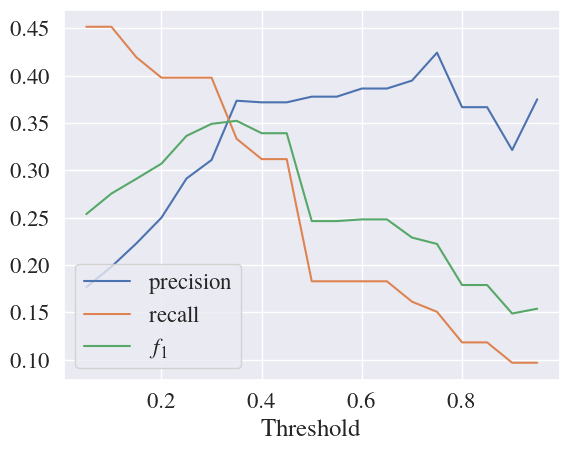

In [114]:
metric_ploter(calibration_prediction_XGB, y_calib)

In [116]:
metric_printer(prediction_XGB, y_test, 0.3)
metric_printer(prediction_XGB, y_test)

Threshold: 0.3
Precision: 0.24
Recall: 0.24
f1 score: 0.24
ROC-AUC: 0.67
Confunsion matrix:
      0    1
0  5994  177
1   176   56
Threshold: 0.5
Precision: 0.38
Recall: 0.14
f1 score: 0.21
ROC-AUC: 0.67
Confunsion matrix:
      0   1
0  6116  55
1   199  33


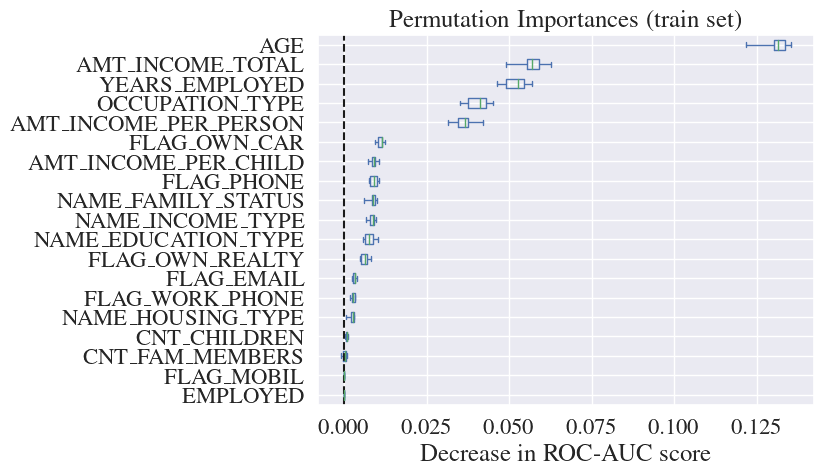

In [177]:
result = permutation_importance(
    pipeline_XGB_optimal, X_train, y_train, n_repeats=10, random_state=42, n_jobs=-1, scoring='roc_auc'
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in ROC-AUC score")
save_plot('PermutationImportanceXGB.pdf')
plt.show()

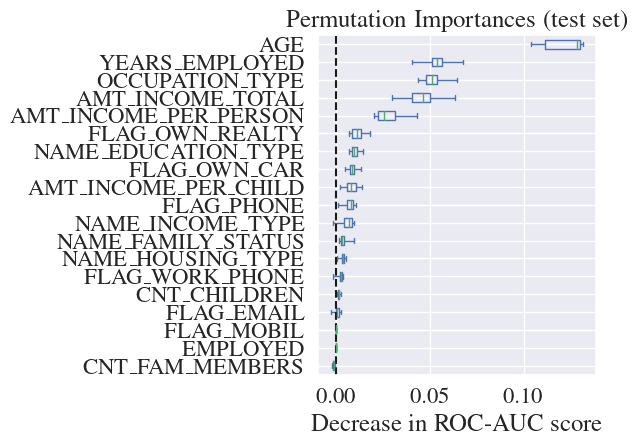

In [176]:
result = permutation_importance(
    pipeline_XGB_optimal, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1, scoring='roc_auc'
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in ROC-AUC score")
ax.figure.tight_layout()

## Part 2: Rejected inference

Based on the strategy discussed inb this lecture https://www.youtube.com/watch?v=CJeMJfUYwkM&ab_channel=BuildingNubank (in portuguese).

"Reject inference is a method for improving the quality of a credit scorecard by incorporating data from rejected loan applications. Bias can result if a credit scorecard model is built only on accepts and does not account for applications rejected because of past denials for credit or unknown nondefault status. By using the reject inference method, you can infer the performance of rejects and include them in your credit scorecard model to remedy this bias.

To develop a credit scorecard, you must identify each borrower as either "good" or "bad". For rejected applications, information to identify borrowers as "good" or "bad" is not available. You cannot tell for sure to which group a borrower would have belonged had they been granted a loan. The reject inference method allows you to infer whether a borrower would likely be "good" or "bad" enabling you to incorporate the rejected application data into the data set that you use to build a credit scorecard.

The workflow for the reject inference process is:

    Build a logistic regression model based on the accepts.

    Infer the class of rejects using one of the reject inference techniques.

    Combine the accepts and rejects into a single data set.

    Create a new scorecard, bin the expanded data set, and build a new logistic model.

    Validate the final model.

There are two types of reject inference:

    Simple assignment does not use a reject inference process and either ignores rejects or assigns all rejects to the "bad" class.

    Augmentation uses a reject inference process to handle rejects based on a scoring model by combining the original data set with the rejects data. 

This example focuses on augmentation techniques. The most popular techniques for augmentation are:


    Fuzzy augmentation — This method scores the rejects by using a credit scorecard model based on the accepts. These rejects are duplicated into two observations, where each is assigned a probability of being "good" or "bad," and then aggregated to the accepts. A new credit scorecard model is then estimated on the new data set." 
(text taken from https://www.mathworks.com/help/risk/reject-inference-for-credit-scorecards.html )



* We have a rule $\cal{M}$ that approves or not the credit for a client.
* People who are rejected are a **hidden target**, because since we are not providing credit we do not have information about then. 
    * In our dataset they are represented by people with no loan, "X" or -1 in our encoding.
    * The idea here is simple "We have to bet to gain information". We'll only know if someone is a good client if we actually provide credit to this person, otherwise we'll never know.

**Counterfactual problem:** Let's assume we change the rule $\cal{M}$ (my client_classifier(id) function) by $\cal{M}^{\prime}$ (client_classifier2(id) below) and we **randomly** select people that the rule $\cal{M}$ has rejected and approve their credit line.
* In this case, some of them might turn out to be actually good clients and other were really bad clients. By doing so we obtain information about the rejected people. 
* The important thing to take into account here is **what is the cost of the true negatives?** 
    * We use the confusion matrix to infer it.

**1st step:** I'll create two dataset out of the original df_clean. A df_accepted that will be used to train the best model and a df_rejected.

The rejection rule ${\cal M}$ that I consider is that people younger than 30 years old OR with an total amount income less than 40000 can't have a credit card.

https://altair.com/newsroom/articles/credit-scoring-series-part-six-segmentation-and-reject-inference

In [119]:
df_accepted = df_work[(df_work['AGE'] >= 30) | (df_work['AMT_INCOME_TOTAL'] >= 40000)]

df_rejected = df_work[(df_work['AGE'] < 30) | (df_work['AMT_INCOME_TOTAL'] < 40000)]


In [120]:
df_accepted['AGE'].mean(), df_accepted['AMT_INCOME_TOTAL'].mean(), df_rejected['AGE'].mean(), df_rejected['AMT_INCOME_TOTAL'].mean()

(43.87877178734304, 185793.5355000937, 27.411398705823792, 178520.974987556)

In [121]:
# Obtain target and predictors
y_accepted = df_accepted.CLIENT_CLASSIFICATION

# The "hidden" target is given by:
y_rejected = df_rejected.CLIENT_CLASSIFICATION

# I take off the ID and GENDER and the target
X_accepted = df_accepted.drop(['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION'], axis = 1)

X_rejected = df_rejected.drop(['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION'], axis = 1)

# The columns that has numerical features
#numerical_features = X_accepted.select_dtypes(include=['float64', 'int64']).columns

# The categorical features
#categorical_features = X_accepted.select_dtypes(include=['object']).columns

In [122]:
X_accepted_train, X_accepted_test, y_accepted_train, y_accepted_test = train_test_split(X_accepted, y_accepted, test_size=0.2, random_state=42, stratify = y_accepted)

# Defining the training and threshold verification sets
X_accepted_train, X_accepted_calib, y_accepted_train, y_accepted_calib = train_test_split(X_accepted_train, y_accepted_train, test_size = 0.1, random_state = 42, stratify = y_accepted_train)





In [181]:
 # Separate the target variables for accepted and rejected applicants
y_accepted = df_accepted['CLIENT_CLASSIFICATION']
y_rejected = df_rejected['CLIENT_CLASSIFICATION']

# Remove unnecessary columns
features_to_drop = ['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION']
X_accepted = df_accepted.drop(features_to_drop, axis=1)
X_rejected = df_rejected.drop(features_to_drop, axis=1)

# Split the accepted data into training and test sets
X_accepted_train, X_accepted_test, y_accepted_train, y_accepted_test = train_test_split(X_accepted, y_accepted, test_size=0.2, random_state=42, stratify=y_accepted)

# Train the model on accepted applicants
model = pipeline_XGB_optimal
model.fit(X_accepted_train, y_accepted_train)

# Make predictions on the rejected dataset
predictions_on_rejected = model.predict_proba(X_rejected)

In [182]:
roc_auc_score(y_rejected, predictions_on_rejected[:,1])

0.9105687238630424

In [187]:
# Define a function for fuzzy augmentation
def fuzzy_augmentation(df_accepted, df_rejected, n_iterations=5):
    # Separate the target variables for accepted and rejected applicants
    y_accepted = df_accepted['CLIENT_CLASSIFICATION']
    y_rejected = df_rejected['CLIENT_CLASSIFICATION']

    # Remove unnecessary columns
    features_to_drop = ['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION']
    X_accepted = df_accepted.drop(features_to_drop, axis=1)
    X_rejected = df_rejected.drop(features_to_drop, axis=1)

    # Split the accepted data into training and test sets
    X_accepted_train, X_accepted_test, y_accepted_train, y_accepted_test = train_test_split(X_accepted, y_accepted, test_size=0.2, random_state=42, stratify=y_accepted)

    # Train the model on accepted applicants
    model = pipeline_XGB_optimal
    model.fit(X_accepted_train, y_accepted_train)

    # Make predictions on the rejected dataset
    predictions_on_rejected = model.predict_proba(X_rejected)
    
    iteration0 = roc_auc_score(y_rejected, predictions_on_rejected[:,1])
    
    roc_list = []
    roc_cheat_list = [iteration0]

    for _ in range(n_iterations):
        # Create a new dataframe with fuzzy strategy
        df_fuzzy_augmented = pd.concat([
            df_rejected.assign(Target=1).assign(sample_weight=predictions_on_rejected[:, 1]),
            df_rejected.assign(Target=0).assign(sample_weight=predictions_on_rejected[:, 0]),
            df_accepted.assign(Target=y_accepted).assign(sample_weight=1)
        ])

        # Separate the target variable and features
        y_fuzzy_augmented = df_fuzzy_augmented['Target']
        X_fuzzy_augmented = df_fuzzy_augmented.drop(features_to_drop + ['Target', 'sample_weight'], axis=1)
        sample_weight_augmented = df_fuzzy_augmented.sample_weight
        
        # Split the fuzzy augmented dataset into training and test sets
        X_fuzzy_train, X_fuzzy_test, y_fuzzy_train, y_fuzzy_test, sample_weight_train, _ = train_test_split(
            X_fuzzy_augmented, 
            y_fuzzy_augmented, 
            sample_weight_augmented,
            test_size=0.2, 
            random_state=42, 
            stratify=y_fuzzy_augmented)

        # Train the model on the fuzzy augmented dataset, taking sample weights into account
        model.fit(X_fuzzy_train, y_fuzzy_train, **{'xgbclassifier__sample_weight': sample_weight_train})
        
        # Make predictions on the fuzzy augmented test set
        predictions_on_fuzzy = model.predict_proba(X_fuzzy_test)

        # Compute the ROC AUC score for the fuzzy augmented dataset
        roc = roc_auc_score(y_fuzzy_test, predictions_on_fuzzy[:, 1])
        roc_list.append(roc)

        # Update the predictions on the rejected dataset
        predictions_on_rejected = model.predict_proba(X_rejected)
        
        roc_cheat_list.append(roc_auc_score(y_rejected, predictions_on_rejected[:, 1]))

    return roc_list, roc_cheat_list, predictions_on_rejected

In [188]:
%%time
# Example usage:
roc_list, roc_cheat_list, predicted_probs = fuzzy_augmentation(df_accepted, df_rejected, n_iterations=5)
print("ROC AUC scores on fuzzy augmented dataset:", roc_list)
print("ROC AUC scores on cheated rejected dataset:", roc_cheat_list)

ROC AUC scores on fuzzy augmented dataset: [0.5923850639938968, 0.5862930764350323, 0.5776120460663048, 0.5810302856832825, 0.5710362565646477]
ROC AUC scores on cheated rejected dataset: [0.9105687238630424, 0.9558088027095313, 0.9539438218766336, 0.9566214987367136, 0.9545142065255271, 0.9467180421240634]
CPU times: user 10min 1s, sys: 5min 16s, total: 15min 18s
Wall time: 1min 16s


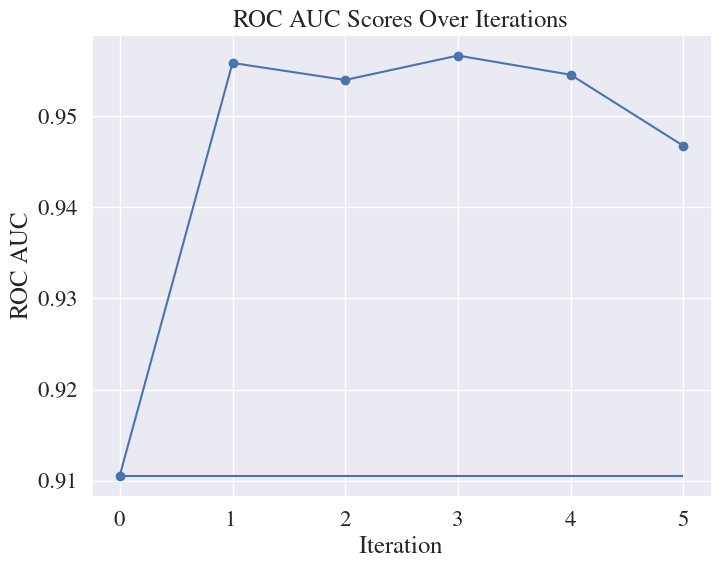

In [195]:
# Sample data (replace with your actual data)
iterations = list(range(0, len(roc_cheat_list)))
roc_auc_scores = roc_cheat_list
#calibration_data = [(0.1, 0.15), (0.2, 0.22), (0.3, 0.28), (0.4, 0.38)]  # Replace with your calibration data

# Create a plot for ROC AUC scores over iterations
plt.figure(figsize=(8, 6))
plt.plot(iterations, roc_auc_scores, marker='o', linestyle='-', color='b')
plt.title("ROC AUC Scores Over Iterations")
plt.xlabel("Iteration")
plt.ylabel("ROC AUC")
plt.hlines(roc_cheat_list[0], 0, len(roc_cheat_list)-1)
plt.grid(True)
save_plot("ROC-AUCOveriterations.pdf")
plt.show()

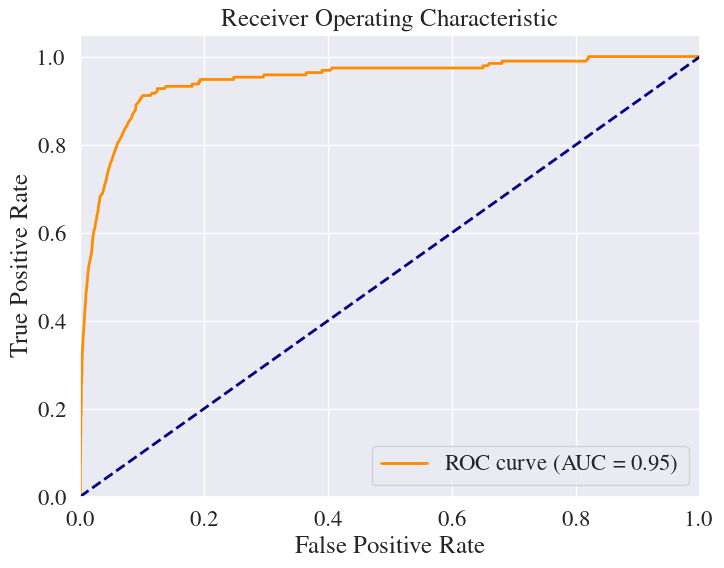

In [196]:
# Assuming you have true_labels and predicted_probs for a specific iteration
true_labels = y_rejected

fpr, tpr, _ = roc_curve(true_labels, predicted_probs[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.grid(True)
save_plot("Cheated-ROC-AUC.pdf")
plt.show()

* This high ROC compared to the "cheat" known values (of course in the real world we wouldn't have this informaton) shows that the model is correctly predicting the new clients.

## Conclusions

### Pet Cematary

In [188]:
%%time
rejected_inference_results = fuzzy_augmentation(10)
rejected_inference_results[1]

CPU times: user 23min 46s, sys: 42.8 s, total: 24min 29s
Wall time: 1min 42s


[0.5923850639938968,
 0.5862930764350323,
 0.5776120460663048,
 0.5810302856832825,
 0.5710362565646477,
 0.5682863155260631,
 0.5649221930767672,
 0.5645987357343825,
 0.56481970263516,
 0.5628972283152094]

In [183]:
roc_auc_score(y_rejected, making_predictions_on_fuzzy[:,1])

ValueError: Found input variables with inconsistent numbers of samples: [4018, 8010]

In [120]:
# Train the best pipeline_XGB_optimal chosen in the part 1
training_the_model_on_accepted = pipeline_XGB_optimal.fit(X_accepted_train, y_accepted_train)

In [121]:
training_the_model_on_accepted

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_features',
                                                  RobustScaler(),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'AGE', 'YEARS_EMPLOYED',
       'EMPLOYED', 'AMT_INCOME_PER_PERSON', 'AMT_INCOME_PER_CHILD'],
      dtype='object')),
                                                 ('categorical_features',
                                                  Targe...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=27, max_leaves=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=266,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [122]:
    # Make the predictions in the rejected dataset
making_predictions_on_rejected = pipeline_XGB_optimal.predict_proba(X_rejected)

In [123]:
making_predictions_on_rejected

array([[9.9927914e-01, 7.2085072e-04],
       [9.9927914e-01, 7.2085072e-04],
       [9.9979836e-01, 2.0166011e-04],
       ...,
       [9.9558872e-01, 4.4112797e-03],
       [2.5052088e-01, 7.4947912e-01],
       [9.9996036e-01, 3.9649894e-05]], dtype=float32)

In [124]:
    #Make hard prediction in the rejected set
hard_predictions_on_rejected = pipeline_XGB_optimal.predict(X_rejected)

In [125]:
hard_predictions_on_rejected

array([0, 0, 0, ..., 0, 1, 0])

In [126]:
df_fuzzy_augmented = pd.concat(
            [df_rejected.assign(Target = 1).assign(sample_weight = making_predictions_on_rejected[:,1]), # Put the rejected clients with the label of bad clients with the probability given by the predict_proba.
             df_rejected.assign(Target = 0).assign(sample_weight = making_predictions_on_rejected[:,0]), # Now, the same guys are put with the label of good clients.
             df_accepted.assign(Target = lambda df_: df_.CLIENT_CLASSIFICATION).assign(sample_weight = 1)]
        )

In [127]:
df_fuzzy_augmented

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION,AGE,YEARS_EMPLOYED,EMPLOYED,AMT_INCOME_PER_PERSON,AMT_INCOME_PER_CHILD,Target,sample_weight
18,5008825,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,...,Accountants,2.0,0,29.0,3.0,1,65250.0,-1.0,1,0.000721
19,5008826,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,...,Accountants,2.0,0,29.0,3.0,1,65250.0,-1.0,1,0.000721
20,5008830,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,Laborers,2.0,0,27.0,4.0,1,78750.0,-1.0,1,0.000202
21,5008831,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,Laborers,2.0,0,27.0,4.0,1,78750.0,-1.0,1,0.000202
22,5008832,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,Laborers,2.0,0,27.0,4.0,1,78750.0,-1.0,1,0.000202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,Managers,2.0,1,47.0,7.0,1,157500.0,-1.0,1,1.000000
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,Medicine staff,2.0,0,34.0,4.0,1,78750.0,-1.0,0,1.000000
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,Medicine staff,2.0,0,34.0,4.0,1,78750.0,-1.0,0,1.000000
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,Sales staff,2.0,1,49.0,2.0,1,141750.0,-1.0,1,1.000000


In [129]:
 # Obtain target
y_fuzzy_augmented = df_fuzzy_augmented.Target
y_fuzzy_augmented

18       1
19       1
20       1
21       1
22       1
        ..
36452    1
36453    0
36454    0
36455    1
36456    0
Name: Target, Length: 40050, dtype: int64

In [137]:
        # I take off the ID and GENDER, Target and sample_weight
X_fuzzy_augmented = df_fuzzy_augmented.drop(['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION', 'Target'], axis = 1)
X_fuzzy_augmented

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED,EMPLOYED,AMT_INCOME_PER_PERSON,AMT_INCOME_PER_CHILD,sample_weight
18,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,1,0,0,0,Accountants,2.0,29.0,3.0,1,65250.0,-1.0,0.000721
19,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,1,0,0,0,Accountants,2.0,29.0,3.0,1,65250.0,-1.0,0.000721
20,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,1,0,Laborers,2.0,27.0,4.0,1,78750.0,-1.0,0.000202
21,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,1,0,Laborers,2.0,27.0,4.0,1,78750.0,-1.0,0.000202
22,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,1,0,Laborers,2.0,27.0,4.0,1,78750.0,-1.0,0.000202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Managers,2.0,47.0,7.0,1,157500.0,-1.0,1.000000
36453,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,34.0,4.0,1,78750.0,-1.0,1.000000
36454,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,1,0,1,1,Medicine staff,2.0,34.0,4.0,1,78750.0,-1.0,1.000000
36455,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Sales staff,2.0,49.0,2.0,1,141750.0,-1.0,1.000000


In [138]:
# Now make the training and test sets of the fuzzy
X_fuzzy_train, X_fuzzy_test, y_fuzzy_train, y_fuzzy_test = train_test_split(X_fuzzy_augmented, y_fuzzy_augmented, test_size=0.2, random_state=42, stratify = y_fuzzy_augmented)



In [139]:
  # Take the sample weights that are going to be provided to the model
sample_weights = X_fuzzy_train['sample_weight']
sample_weights

19748    1.000000
35479    1.000000
16585    1.000000
24113    1.000000
25147    0.000315
           ...   
28080    1.000000
34571    0.166163
23169    1.000000
27392    1.000000
19093    1.000000
Name: sample_weight, Length: 32040, dtype: float64

In [145]:
X_fuzzy_train = X_fuzzy_train.drop(['sample_weight'], axis = 1)

In [146]:
X_fuzzy_train

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED,EMPLOYED,AMT_INCOME_PER_PERSON,AMT_INCOME_PER_CHILD
19748,Y,N,0,90000.0,Pensioner,Higher education,Widow,House / apartment,1,0,0,0,Not provided,1.0,66.0,-1.0,0,90000.0,-1.0
35479,Y,Y,0,238500.0,Working,Higher education,Married,With parents,1,0,0,0,Laborers,2.0,33.0,7.0,1,119250.0,-1.0
16585,N,Y,0,180000.0,Working,Secondary / secondary special,Single / not married,House / apartment,1,1,0,0,Security staff,1.0,42.0,3.0,1,180000.0,-1.0
24113,N,N,0,81000.0,Pensioner,Secondary / secondary special,Married,House / apartment,1,0,0,0,Not provided,2.0,55.0,-1.0,0,40500.0,-1.0
25147,N,N,1,90000.0,Pensioner,Secondary / secondary special,Married,House / apartment,1,0,0,0,Not provided,3.0,27.0,-1.0,0,30000.0,90000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28080,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,1,0,Core staff,2.0,32.0,2.0,1,56250.0,-1.0
34571,N,Y,0,157500.0,Working,Higher education,Civil marriage,With parents,1,0,0,0,Accountants,2.0,23.0,2.0,1,78750.0,-1.0
23169,Y,Y,0,135000.0,Working,Higher education,Married,House / apartment,1,0,0,1,Not provided,2.0,42.0,13.0,1,67500.0,-1.0
27392,N,N,0,99000.0,Working,Higher education,Married,House / apartment,1,0,0,0,Not provided,2.0,40.0,15.0,1,49500.0,-1.0


In [147]:
training_the_model_on_the_fuzzy_dataset = pipeline_XGB_optimal.fit(X_fuzzy_train, y_fuzzy_train, **{'xgbclassifier__sample_weight': sample_weights})

# Ta entendi! O sample weigths esta com a dimensao errada. 
# Eu tenho que deixar ele no X, separar o X de test e de treino, salvar o sample weigths do treino, e tirar o sample weigths do X de treino. Ai sim eu posso usar corretamente!

In [148]:
making_predictions_on_fuzzy = pipeline_XGB_optimal.predict_proba(X_fuzzy_test)

In [149]:
roc = roc_auc_score(y_fuzzy_test, making_predictions_on_fuzzy[:,1])
roc

0.5877794300507234

In [ ]:
       
        
        
        print(4)
   
        # Train the model in the fuzzy augmented dataset TAKING INTO ACCOUNT THE SAMPLE WEIGHTS!!! (This is crucial)
        
        print(6)
        # Make the predictions in the fuzzy dataset
        making_predictions_on_fuzzy = pipeline_XGB_optimal.predict_proba(X_fuzzy_test)
        print(8)
        # Compute the roc with the y_fuzzy_test
        roc = roc_auc_score(y_fuzzy_test, making_predictions_on_fuzzy[:,1])
        print(10)
        # Append the value of the roc
        roc_list.append(roc)
        print(11)
        
        # Update the df_rejected (I'm not sure this step is going to work)
        df_rejected = df_fuzzy_augmented

In [109]:
# Train model
XGB_accepted_train = pipeline_XGB_optimal.fit(X_accepted_train, y_accepted_train)

# Make the predictions in the accepted dataset - just to check the ROC-AUC
prediction_XGB_accepted = pipeline_XGB_optimal.predict_proba(X_accepted_test)

# Score the rejected
prediction_XGB_rejected0 = pipeline_XGB_optimal.predict_proba(X_rejected)

In [110]:
roc_auc_score(y_accepted_test, prediction_XGB_accepted[:,1]), roc_auc_score(y_rejected, prediction_XGB_rejected0[:,1])

(0.6654547969087892, 0.8904909119620144)

In [335]:
# Fuzzy augmentation
df_fuzzy_augmented = pd.concat(
    [df_rejected.assign(Target = 1).assign(sample_weight = prediction_XGB_rejected[:,1]), # Put the rejected clients with the label of bad clients with the probability given by the predict_proba.
     df_rejected.assign(Target = 0).assign(sample_weight = prediction_XGB_rejected[:,0]), # Now, the same guys are put with the label of good clients.
     df_accepted.assign(Target = lambda df_: df_.CLIENT_CLASSIFICATION).assign(sample_weight = 1)]
)

In [336]:
df_fuzzy_augmented

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,OCCUPATION_TYPE,CNT_FAM_MEMBERS,CLIENT_CLASSIFICATION,AGE,YEARS_EMPLOYED,EMPLOYED,AMT_INCOME_PER_PERSON,AMT_INCOME_PER_CHILD,Target,sample_weight
18,5008825,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,...,Accountants,2.0,0,29.0,3.0,1,65250.0,-1.0,1,0.000721
19,5008826,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,...,Accountants,2.0,0,29.0,3.0,1,65250.0,-1.0,1,0.000721
20,5008830,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,Laborers,2.0,0,27.0,4.0,1,78750.0,-1.0,1,0.000202
21,5008831,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,Laborers,2.0,0,27.0,4.0,1,78750.0,-1.0,1,0.000202
22,5008832,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,...,Laborers,2.0,0,27.0,4.0,1,78750.0,-1.0,1,0.000202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36452,5149828,M,Y,Y,0,315000.0,Working,Secondary / secondary special,Married,House / apartment,...,Managers,2.0,1,47.0,7.0,1,157500.0,-1.0,1,1.000000
36453,5149834,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,...,Medicine staff,2.0,0,34.0,4.0,1,78750.0,-1.0,0,1.000000
36454,5149838,F,N,Y,0,157500.0,Pensioner,Higher education,Married,House / apartment,...,Medicine staff,2.0,0,34.0,4.0,1,78750.0,-1.0,0,1.000000
36455,5150049,F,N,Y,0,283500.0,Working,Secondary / secondary special,Married,House / apartment,...,Sales staff,2.0,1,49.0,2.0,1,141750.0,-1.0,1,1.000000


At this point I need to use the sample_weigths. This is a crucial step in the rejected inference. The problem I'm facing is that the pipeline.fit() does not accept sample weigths. But, XGB classifier.fit does. There is a solution provided at: https://stackoverflow.com/questions/36205850/sklearn-pipeline-applying-sample-weights-after-applying-a-polynomial-feature-t which I tried to apply but did not work. 

Hence, I'll do the brute force to get the job done. I only have to apply the RobustScaler to the numerical variables and TargetEncoder to the categorical variables. I'll do it by hand outside of the pipeline. And then train my XGBoost with the sample weigths. This process will be repeated until the rocauc between different experiments converge.

In [337]:
# The "hidden" target is given by:
y_fuzzy_augmented = df_fuzzy_augmented.Target

# I take off the ID and GENDER and the target
X_accepted = df_fuzzy_augmented.drop(['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION', 'Target', 'sample_weight'], axis = 1)

sample_weights = df_fuzzy_augmented['sample_weight']

# The columns that has numerical features
#numerical_features_fuzzy = X_fuzzy_augmented.select_dtypes(include=['float64', 'int64']).columns

# The categorical features
#categorical_features_fuzzy = X_fuzzy_augmented.select_dtypes(include=['object']).columns

In [338]:
X_fuzzy_train, X_fuzzy_test, y_fuzzy_train, y_fuzzy_test = train_test_split(X_fuzzy_augmented, y_fuzzy_augmented, test_size=0.2, random_state=42, stratify = y_fuzzy_augmented)

# Defining the training and threshold verification sets
X_fuzzy_train, X_fuzzy_calib, y_fuzzy_train, y_fuzzy_calib = train_test_split(X_fuzzy_train, y_fuzzy_train, test_size = 0.1, random_state = 42, stratify = y_fuzzy_train)




In [135]:
# Fit the XGBoost classifier with sample weights
pipeline_XGB_optimal.fit(X_fuzzy_augmented, y_fuzzy_augmented, **{'xgbclassifier__sample_weight': sample_weights})

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numerical_features',
                                                  RobustScaler(),
                                                  Index(['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'AGE', 'YEARS_EMPLOYED',
       'EMPLOYED', 'AMT_INCOME_PER_PERSON', 'AMT_INCOME_PER_CHILD'],
      dtype='object')),
                                                 ('categorical_features',
                                                  Targe...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=27, max_leaves=5,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=266,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [340]:
# Make the predictions in the rejected dataset
prediction_fuzzy_rejected = pipeline_XGB_optimal.predict_proba(X_rejected)[:,1]
prediction_fuzzy_rejected

array([3.2140865e-04, 3.2140865e-04, 5.4528471e-04, ..., 5.7166632e-02,
       6.7365140e-01, 1.3599223e-04], dtype=float32)

In [345]:
prediction_XGB_rejected0[:,1]

array([7.2085072e-04, 7.2085072e-04, 2.0166011e-04, ..., 4.4112797e-03,
       7.4947912e-01, 3.9649894e-05], dtype=float32)

In [344]:
prediction_fuzzy_rejected

array([3.2140865e-04, 3.2140865e-04, 5.4528471e-04, ..., 5.7166632e-02,
       6.7365140e-01, 1.3599223e-04], dtype=float32)

In [347]:
y_rejected

18       0
19       0
20       0
21       0
22       0
        ..
36429    0
36430    1
36431    0
36449    1
36456    0
Name: CLIENT_CLASSIFICATION, Length: 4018, dtype: int64

In [349]:
prediction_XGB_rejected0[:,1]>0.5

array([False, False, False, ..., False,  True, False])

In [352]:
roc_auc_score(prediction_XGB_rejected0[:,1]>0.5, prediction_fuzzy_rejected)

0.9990548592562153

In [158]:
%%time
rejected_inference_results = function_draft()
rejected_inference_results[1]

5
1
2
4
6
8
10
11
4
1
2
4
6
8
10
11
3
1
2
4
6
8
10
11
2
1
2
4
6
8
10
11
1
1
2
4
6
8
10
11
CPU times: user 11min 9s, sys: 7.18 s, total: 11min 16s
Wall time: 43.5 s


[0.5877794300507234,
 0.5877794300507234,
 0.5877794300507234,
 0.5877794300507234,
 0.5877794300507234]

In [187]:
def fuzzy_augmentation_draft(n_iterations = 5, df_accepted = df_accepted, df_rejected = df_rejected):
    
    # Obtain target on the accepted
    y_accepted = df_accepted.CLIENT_CLASSIFICATION
    
    # The "hidden" target is given by
    y_rejected = df_rejected.CLIENT_CLASSIFICATION

    # I take off the ID and GENDER and the target
    X_accepted = df_accepted.drop(['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION'], axis = 1)

    X_rejected = df_rejected.drop(['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION'], axis = 1)
    
    # Training and test set on the accepted (is it really necessary?)
    X_accepted_train, X_accepted_test, y_accepted_train, y_accepted_test = train_test_split(X_accepted, y_accepted, test_size=0.2, random_state=42, stratify = y_accepted)
    
    # Train the best pipeline_XGB_optimal chosen in the part 1
    training_the_model_on_accepted = pipeline_XGB_optimal.fit(X_accepted_train, y_accepted_train)

    # Make the predictions in the rejected dataset
    making_predictions_on_rejected = pipeline_XGB_optimal.predict_proba(X_rejected)
    
    # Initiate a roc_auc list
    roc_list = []
    roc_cheat_list = []
    
    while n_iterations > 0:
        
        # Create a new dataframe with the fuzzy strategy - This is the core of the rejected inference
        df_fuzzy_augmented = pd.concat(
            [df_rejected.assign(Target = 1).assign(sample_weight = making_predictions_on_rejected[:,1]), # Put the rejected clients with the label of bad clients with the probability given by the predict_proba.
             df_rejected.assign(Target = 0).assign(sample_weight = making_predictions_on_rejected[:,0]), # Now, the same guys are put with the label of good clients.
             df_accepted.assign(Target = lambda df_: df_.CLIENT_CLASSIFICATION).assign(sample_weight = 1)]
        )

        # Obtain target
        y_fuzzy_augmented = df_fuzzy_augmented.Target

        # I take off the ID and GENDER, Target 
        X_fuzzy_augmented = df_fuzzy_augmented.drop(['ID', 'CODE_GENDER', 'CLIENT_CLASSIFICATION', 'Target'], axis = 1)
        
        # Now make the training and test sets of the fuzzy
        X_fuzzy_train, X_fuzzy_test, y_fuzzy_train, y_fuzzy_test = train_test_split(X_fuzzy_augmented, y_fuzzy_augmented, test_size=0.2, random_state=42, stratify = y_fuzzy_augmented)
        
        # Get the sample weights
        sample_weights = X_fuzzy_train['sample_weight']
        
        # Drop the sample weights from the feature
        X_fuzzy_train = X_fuzzy_train.drop(['sample_weight'], axis = 1)
        
        # Train the model in the fuzzy augmented dataset TAKING INTO ACCOUNT THE SAMPLE WEIGHTS!!! (This is crucial)
        training_the_model_on_the_fuzzy_dataset = pipeline_XGB_optimal.fit(X_fuzzy_train, y_fuzzy_train, **{'xgbclassifier__sample_weight': sample_weights})

        # Make the predictions in the fuzzy dataset
        making_predictions_on_fuzzy = pipeline_XGB_optimal.predict_proba(X_fuzzy_test)

        # Compute the roc with the y_fuzzy_test
        roc = roc_auc_score(y_fuzzy_test, making_predictions_on_fuzzy[:,1])
  
        # Append the value of the roc
        roc_list.append(roc)
        
        # Update the df_rejected (I'm not sure this step is going to work)
        making_predictions_on_rejected = pipeline_XGB_optimal.predict_proba(X_rejected)
        
        roc_cheat_list.append(roc_auc_score(y_rejected, making_predictions_on_rejected[:,1]))
        
        # Update the n_iterations
        n_iterations -= 1
    
    return [roc, roc_list, roc_cheat_list, making_predictions_on_fuzzy]

In [103]:
import sklearn
print(sklearn.show_versions())


System:
    python: 3.11.3 (main, Apr 19 2023, 18:51:09) [Clang 14.0.6 ]
executable: /Users/brunogoes/anaconda3/bin/python
   machine: macOS-10.16-x86_64-i386-64bit

Python dependencies:
      sklearn: 1.3.0
          pip: 23.2.1
   setuptools: 67.8.0
        numpy: 1.24.3
        scipy: 1.11.1
       Cython: None
       pandas: 1.5.3
   matplotlib: 3.7.1
       joblib: 1.2.0
threadpoolctl: 2.2.0

Built with OpenMP: True

threadpoolctl info:
       filepath: /Users/brunogoes/anaconda3/lib/libopenblasp-r0.3.21.dylib
         prefix: libopenblas
       user_api: blas
   internal_api: openblas
        version: 0.3.21
    num_threads: 8
threading_layer: pthreads
   architecture: Haswell

       filepath: /Users/brunogoes/anaconda3/lib/libomp.dylib
         prefix: libomp
       user_api: openmp
   internal_api: openmp
        version: None
    num_threads: 16
None
